# Deep One Class Loss

This script demonstrates so called Deep One Class Loss (OCL) presented in paper *Ruff et. al. , Deep One-Class Classification*

The demo shows an amomaly detection with two denseily and uniformly distributed 2D points where anomalies are scattered all over the space (also uniformly)

In [ ]:
# Installing the necessary packages
!pip3 install torch torchvision numpy matplotlib tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision 
from torchvision.datasets import EMNIST
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

plt.rcParams["figure.figsize"] = (20,6)
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
plt.rcParams['text.usetex'] = False

def show_score_map(model, X):
    '''
    This function shows a contour plot of scores in the range of test points in @X
    for a trained model X. 
    '''
    xr = torch.linspace(X[:,0].min(), X[:,0].max(), 1000)
    yr = torch.linspace(X[:,1].min(), X[:,1].max(), 1000)
    x_, y_ = torch.meshgrid(xr, yr)
    X_ = torch.cat((x_.reshape((-1,1)), y_.reshape(-1,1)),1)
    with torch.no_grad():
        s_ = model(X_).reshape(len(xr), len(yr))
        '''
        plt.imshow(s_.T, cmap = 'jet')
        plt.title('score')
        plt.xlabel('x axis')
        plt.ylabel('y axis')
        plt.show()
        '''
        Xt = X - X.min(0, keepdims = True)[0]
        Xt = Xt / Xt.max(0, keepdims = True)[0]
        Xt = Xt * len(xr)
        
        plt.imshow(np.log(s_.T), cmap = 'gray')
        plt.colorbar()
        plt.scatter(Xt[l==1,0],Xt[l==1,1],c = 'b', alpha = 0.05, s = 1)
        plt.scatter(Xt[l==-1,0],Xt[l==-1,1],c = 'r', alpha = 0.25)
        plt.legend(['regular', 'anomalies'])
        
        plt.axis('off')
        plt.title('log score')
        plt.savefig('ocl_contour.pdf')
        plt.show()

def roc(y, l, N = 1000, display = True):
    '''
    Calculates ROC curve for @N thresholds for values of threshold in 
    range (0,y.max())
    '''
    T = torch.linspace(0, y.max(), N)
    tpr, fpr = [],[]
    for T_ in T:
        yt = torch.tensor([(-1 if y_ else 1) for y_ in y > T_])
        tpr.append(torch.logical_and(yt == -1, l == -1).sum() / (l == -1).sum())  
        fpr.append(torch.logical_and(yt == -1, l == 1).sum() / (l == 1).sum())
    if display:
        plt.plot(fpr, tpr, '--')
        plt.xlabel('false positive ratio (FP / N)')
        plt.ylabel('true positive ratio (TP / P)')
        plt.show()
    return tpr, fpr

## Training data - Two moons
This part generates training data for the model. It consists of two overlapping moons (a standard benchmark dataset) with a normal noise with zero mean and unit standard deviation

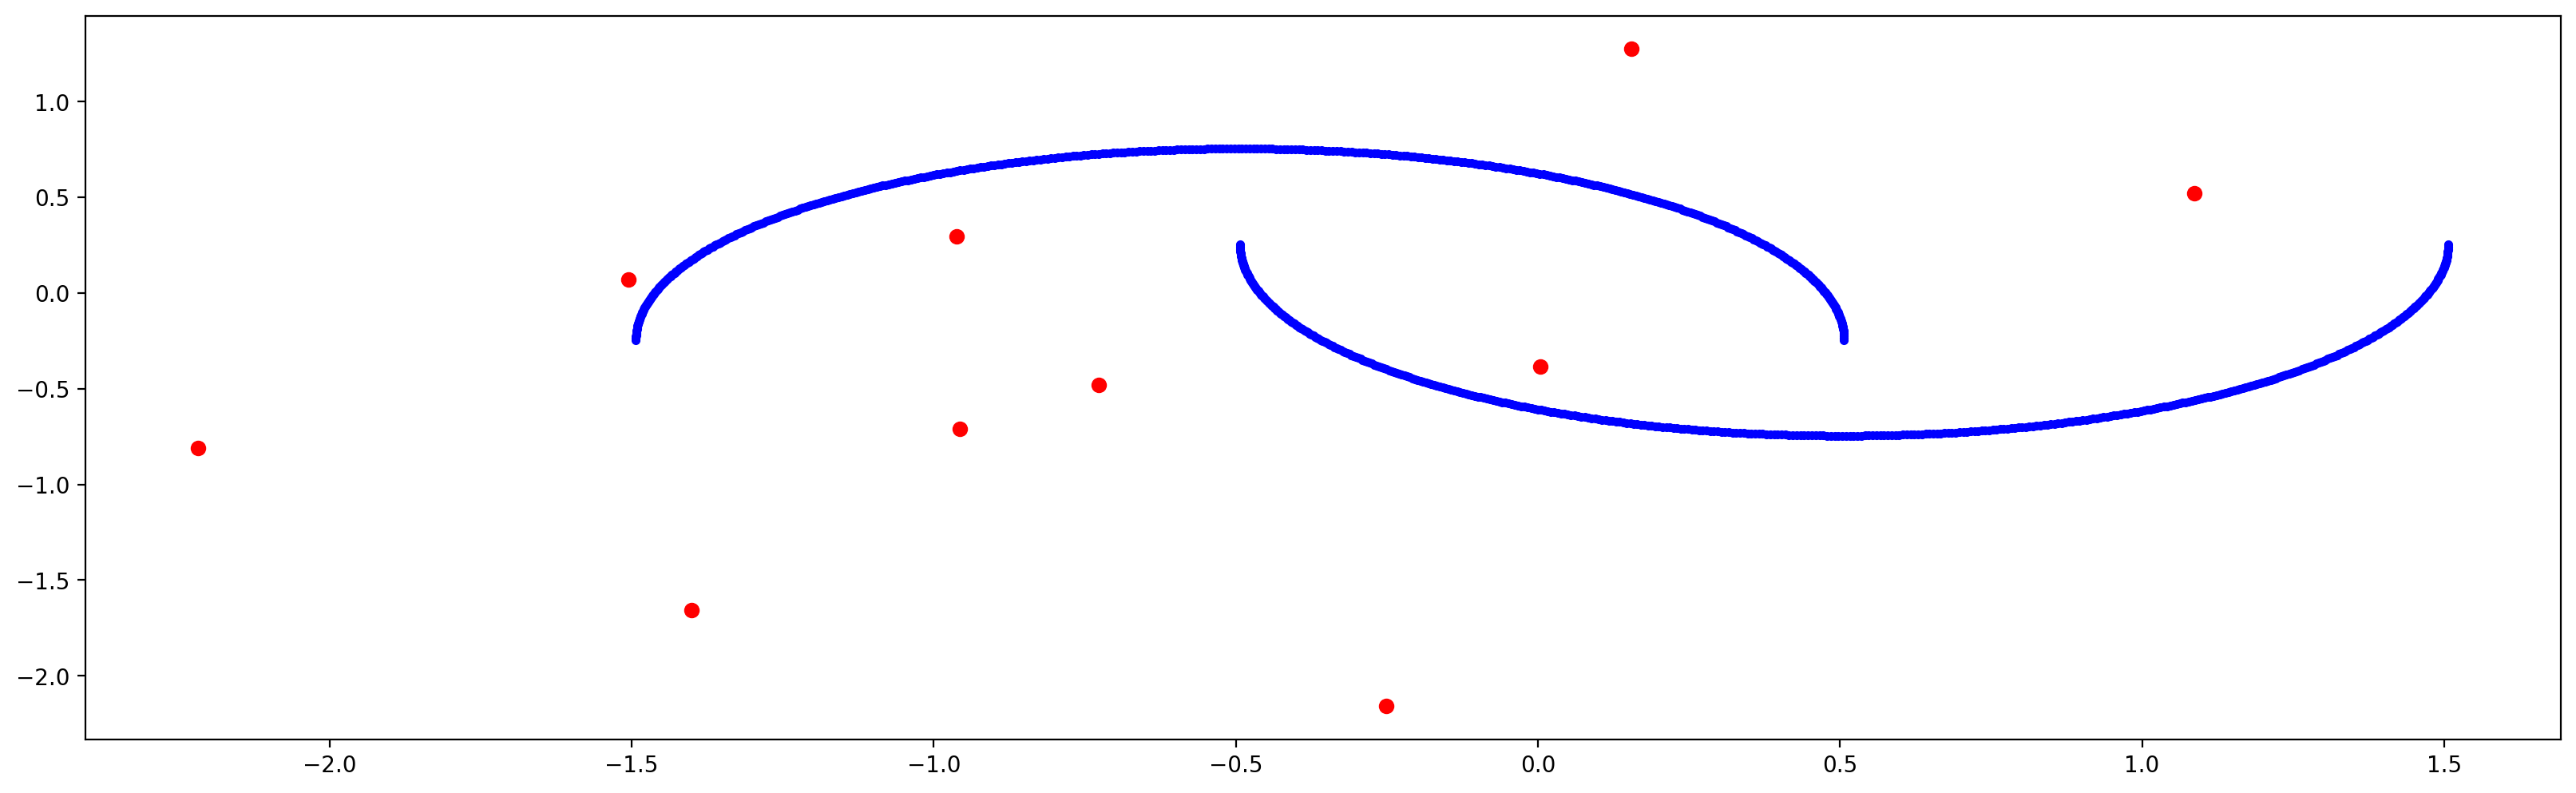

In [ ]:
np.random.seed(42) 
from sklearn.datasets import make_moons
Xn = make_moons(n_samples=1000, noise=False, random_state=42)[0]
Xa = np.random.randn(10,2)
X = np.concatenate((Xn,Xa))
X -= X.mean(0) 

l = torch.cat((torch.ones(Xn.shape[0]), -torch.ones(Xa.shape[0])))

plt.plot(X[l==1,0],X[l==1,1],'b.')
plt.plot(X[l==-1,0],X[l==-1,1],'ro')
# plt.title('Generated Samples')
plt.show()

Xn_test = make_moons(n_samples=5000, noise=False, random_state=42)[0]
Xa_test = np.random.randn(5000,2)
X_test = np.concatenate((Xn_test,Xa_test))
X_test -= X_test.mean(0) 

l_test = torch.cat((torch.ones(Xn_test.shape[0]), -torch.ones(Xa_test.shape[0])))



### Network Definition and Tranining


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


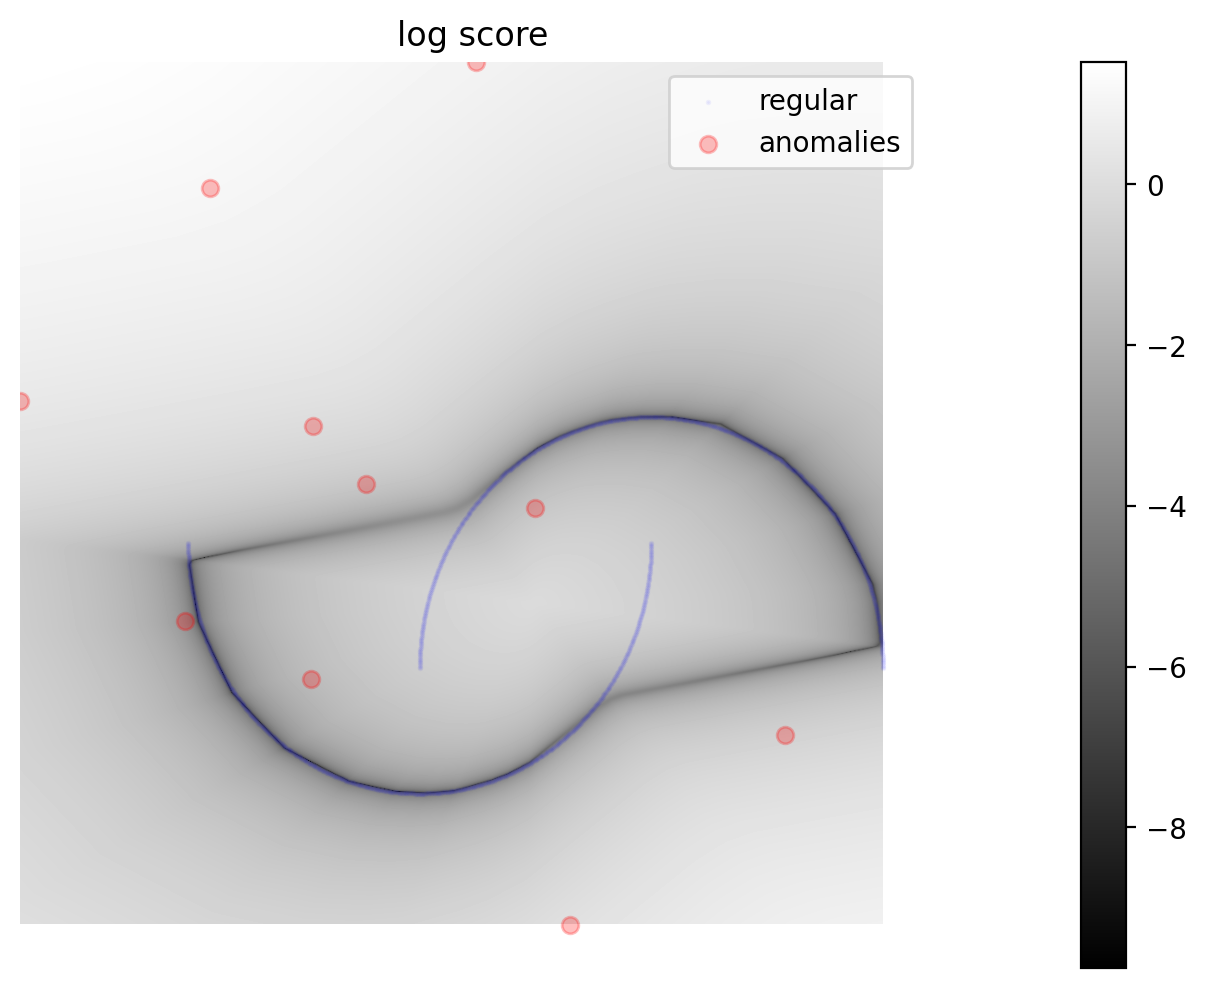

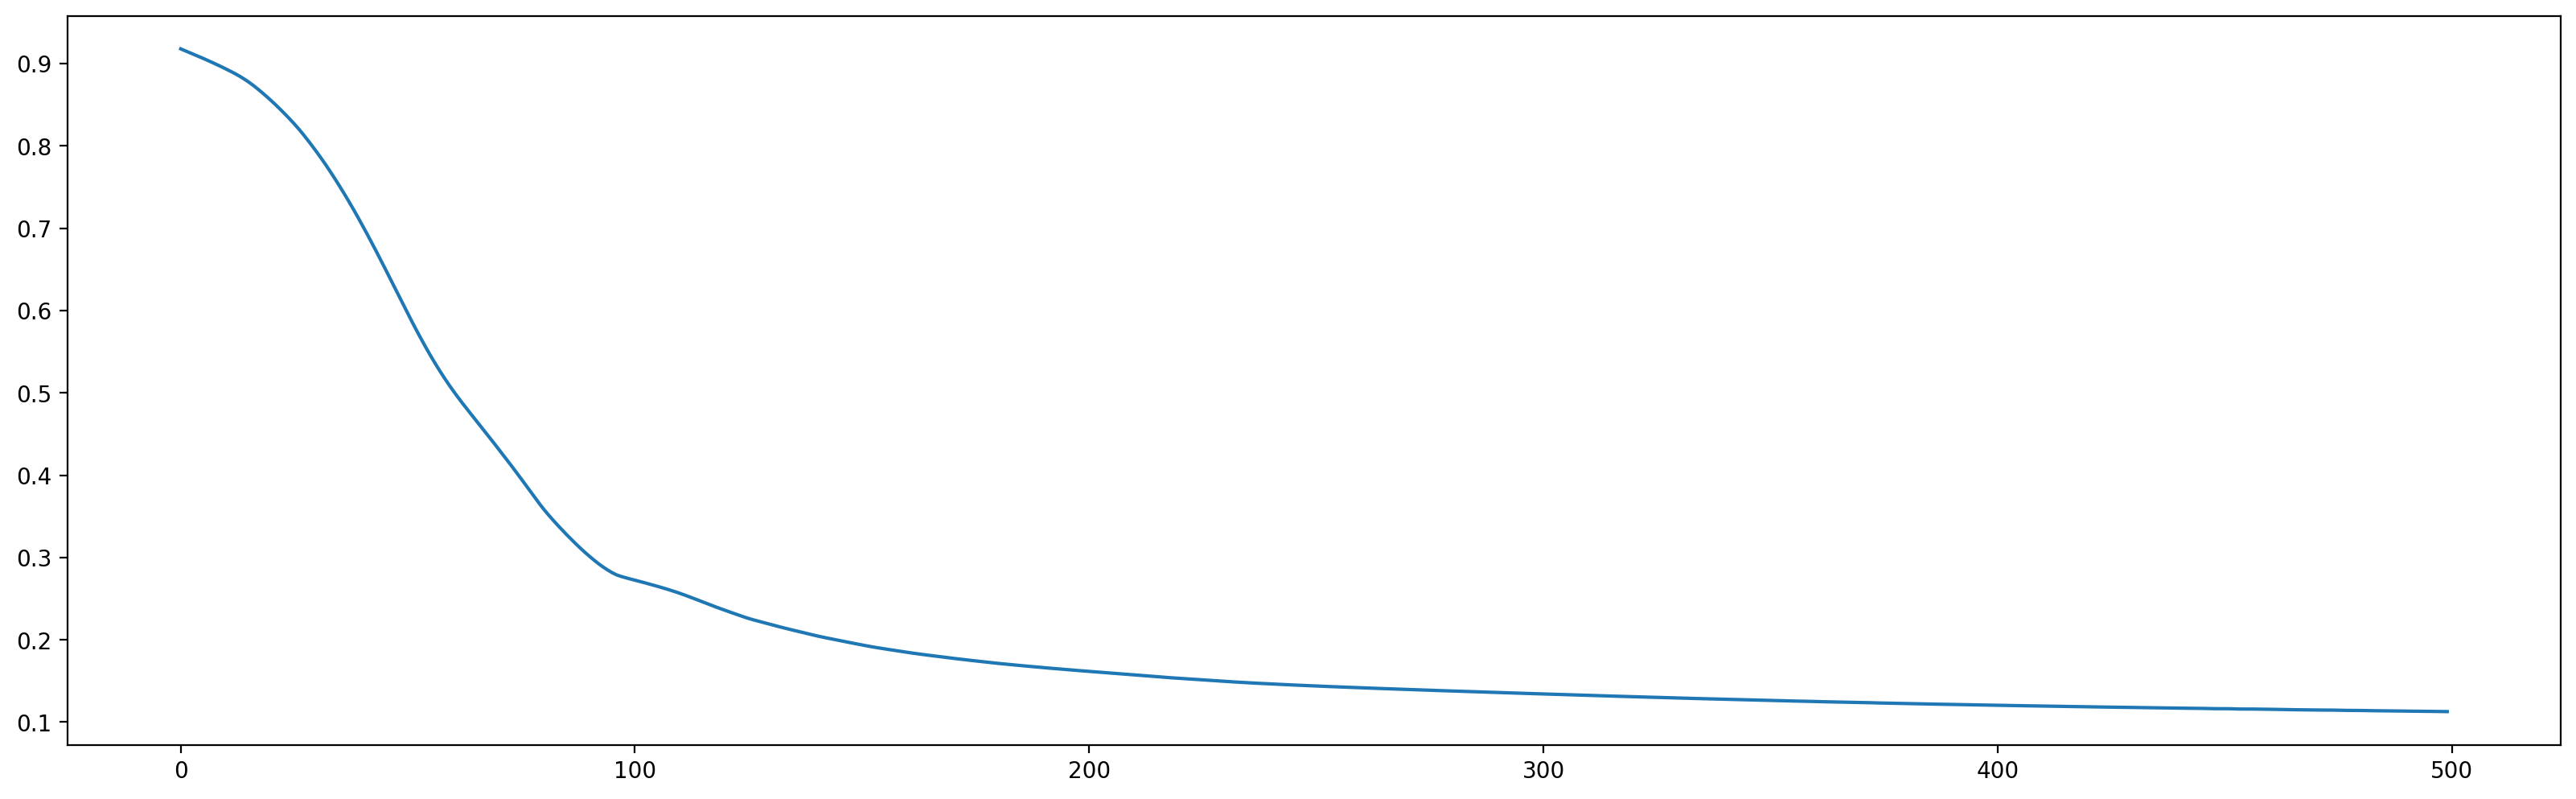

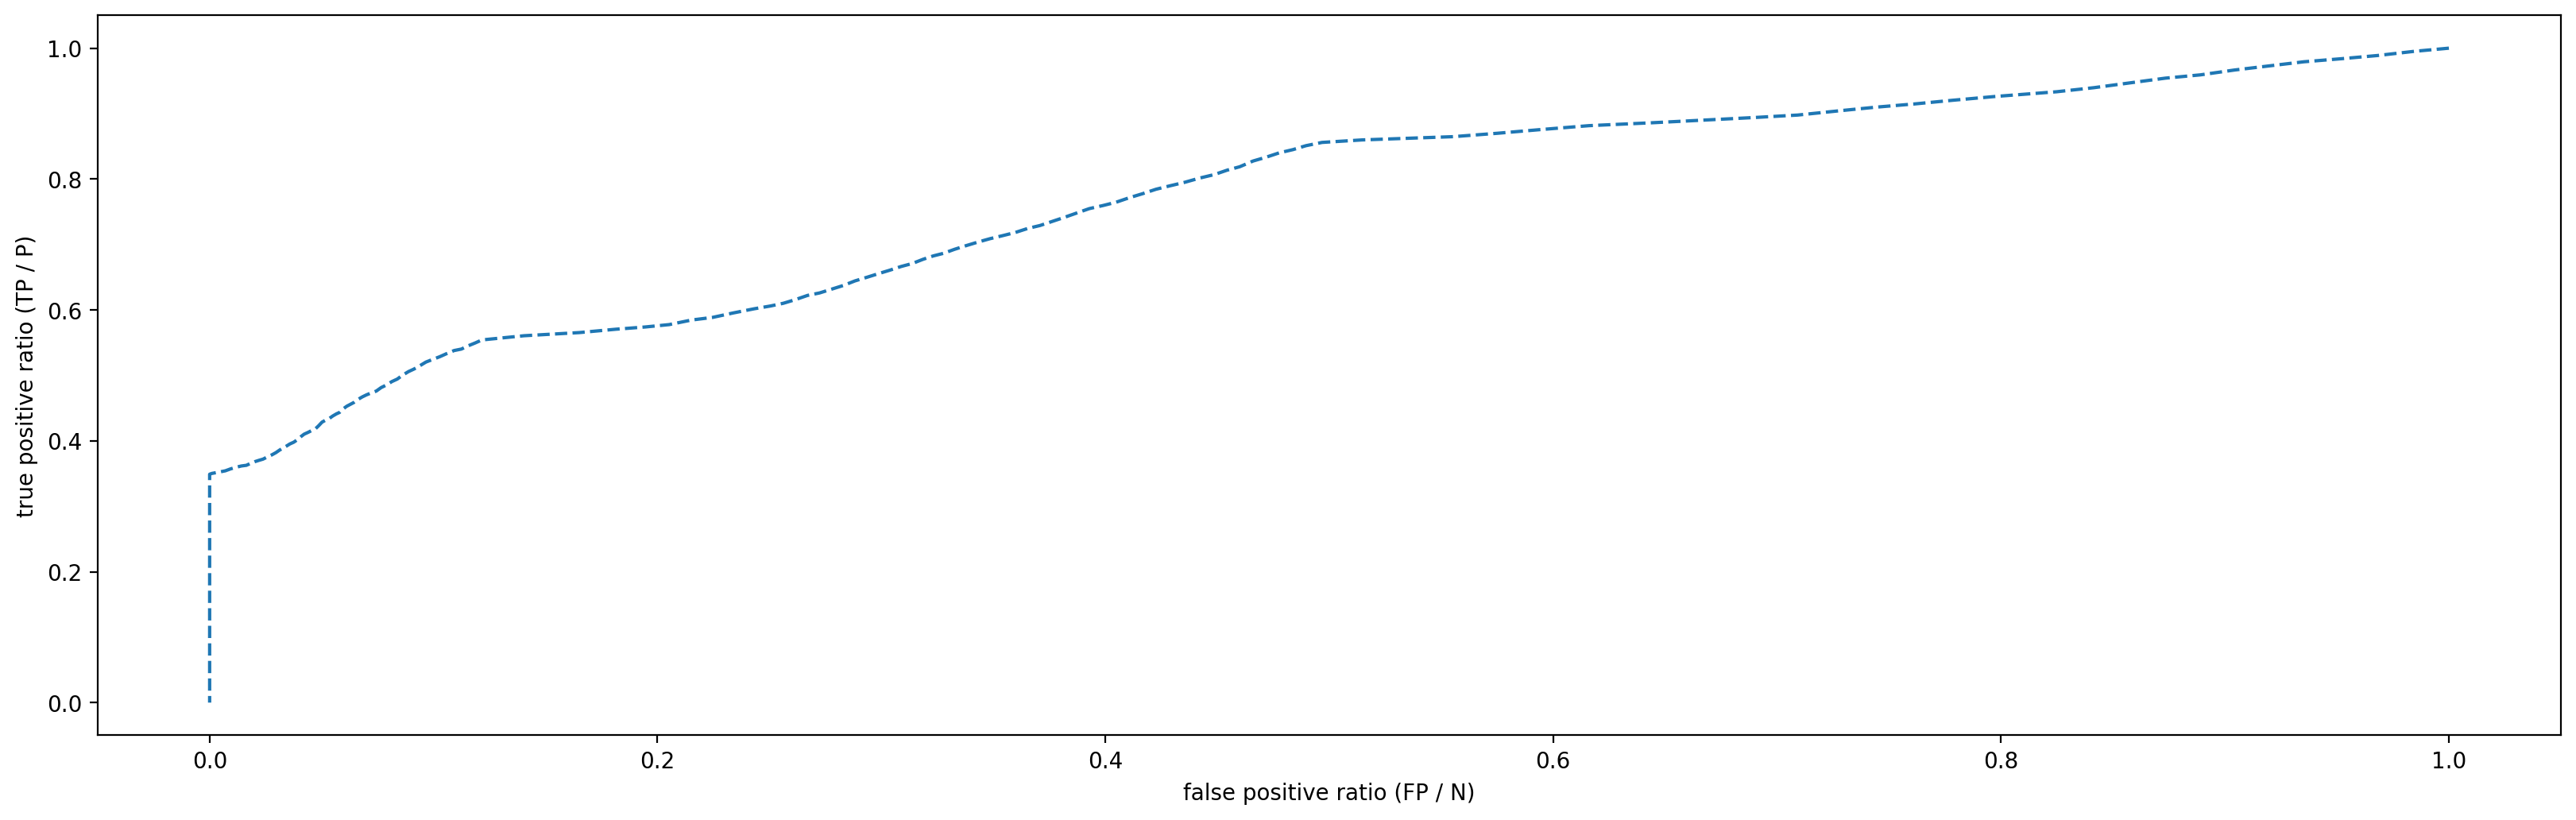

In [ ]:
torch.manual_seed(42) # We always want to have the same results

class LinearOneClass(nn.Module):
    '''
     Linear(2,32) -> ReLU() -> Linear(32,16) -> ReLU() -> Linear(16,8) ->
       ReLU() -> Linear(8,4) -> s = |x-c|_2
    '''
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 32, bias = False),
            nn.ReLU(),
            nn.Linear(32,16, bias = False),
            nn.ReLU(),
            nn.Linear(16,8, bias = False),
            nn.ReLU(),
            nn.Linear(8,4, bias = False))
        self.c = torch.randn((1,4))
    
    def phi(self, x):
        '''
        just projecting datapoints x to the feature space
        '''
        return self.network(x)
    def forward(self, x):
        ''' 
        points are projected to the feature space (4D) and then their projection is substracted from the 
        hypersphere center $c$
        '''
        x = self.phi(x)
        return torch.linalg.vector_norm(x - self.c,dim = -1)
        
epochs = 500
model = LinearOneClass()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
losses = []
for epoch in tqdm(range(epochs)):
    # anomaly score
    s = model(torch.tensor(X).float())
    
    # tranining 
    loss = s.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
show_score_map(model, X)
plt.plot(losses)
plt.show()
s_test = model(torch.tensor(X_test).float()).detach()
tpr, fpr = roc(s_test, l_test)

In [ ]:
torch.save({'fpr' : fpr, 'tpr' : tpr, 'X' : X , 'l' : l, 'model' : model.state_dict()}, 'ocl.torch')

tensor(0.2448)


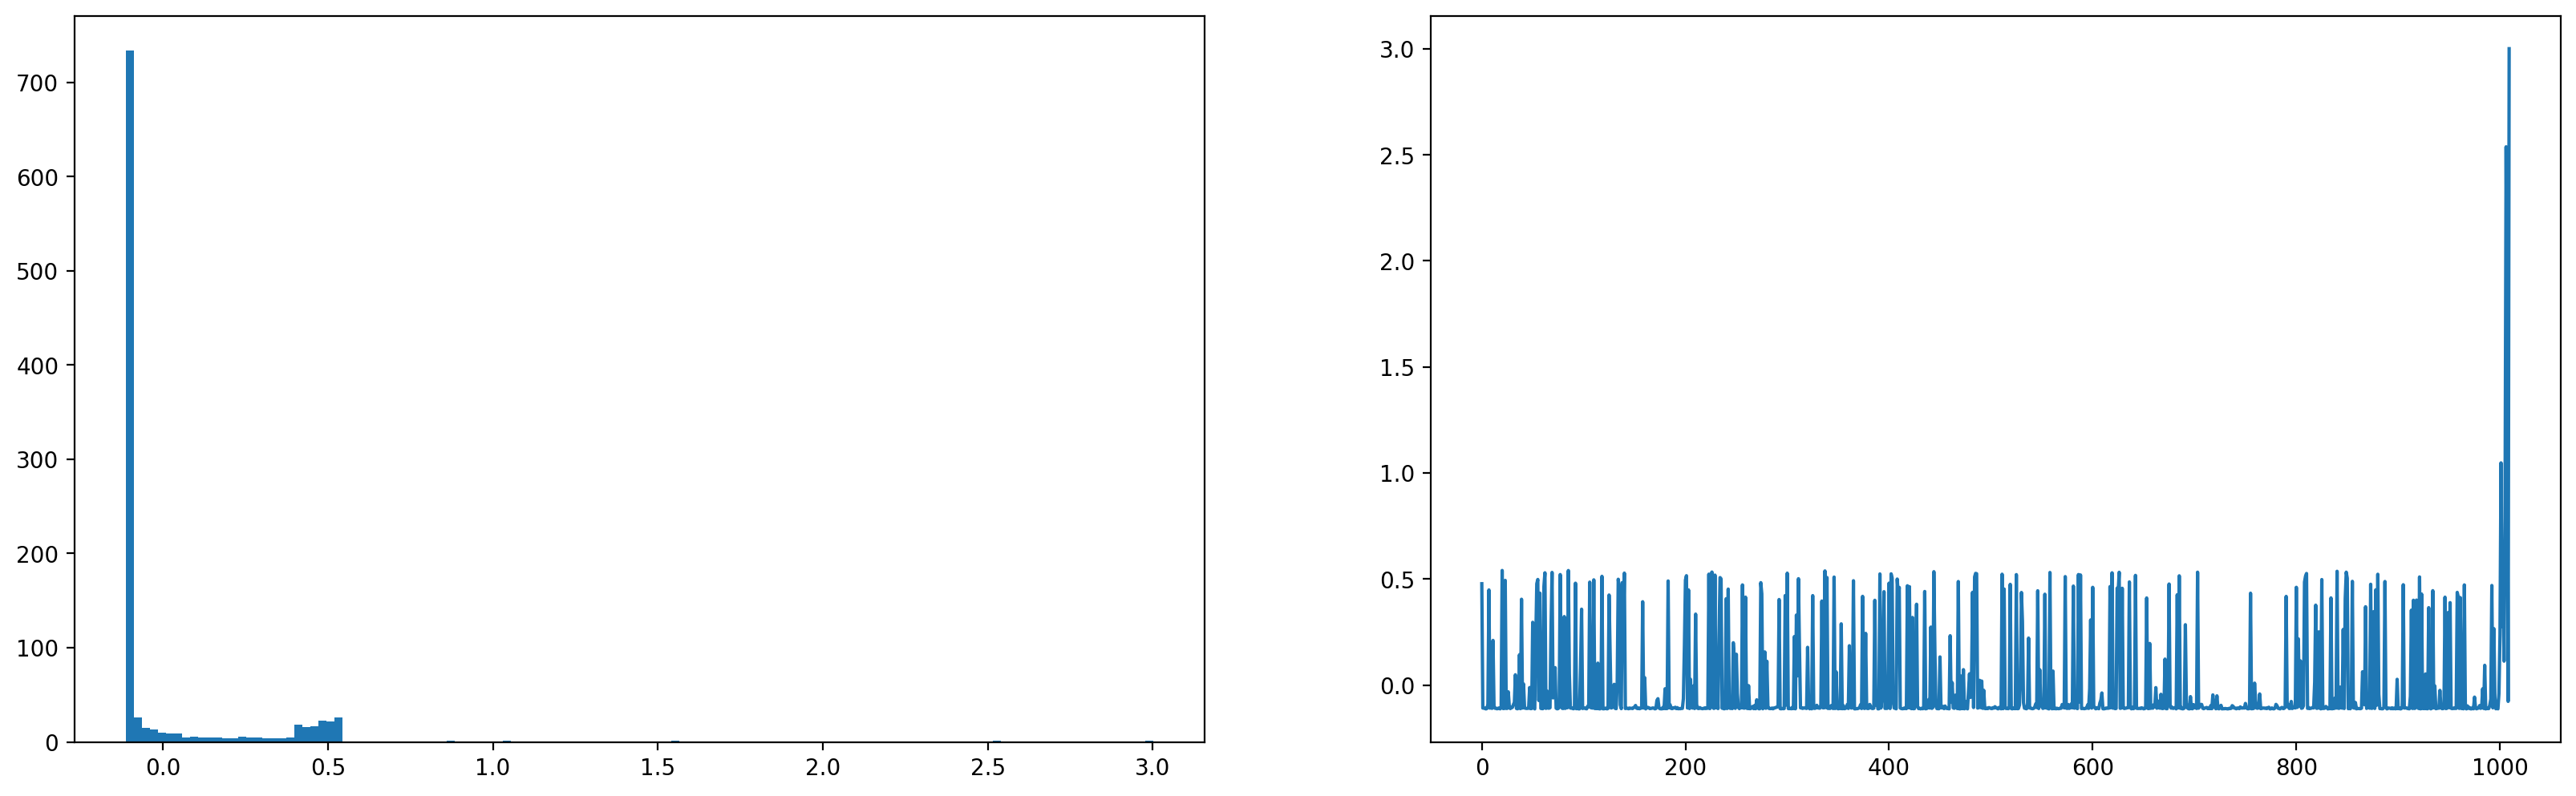

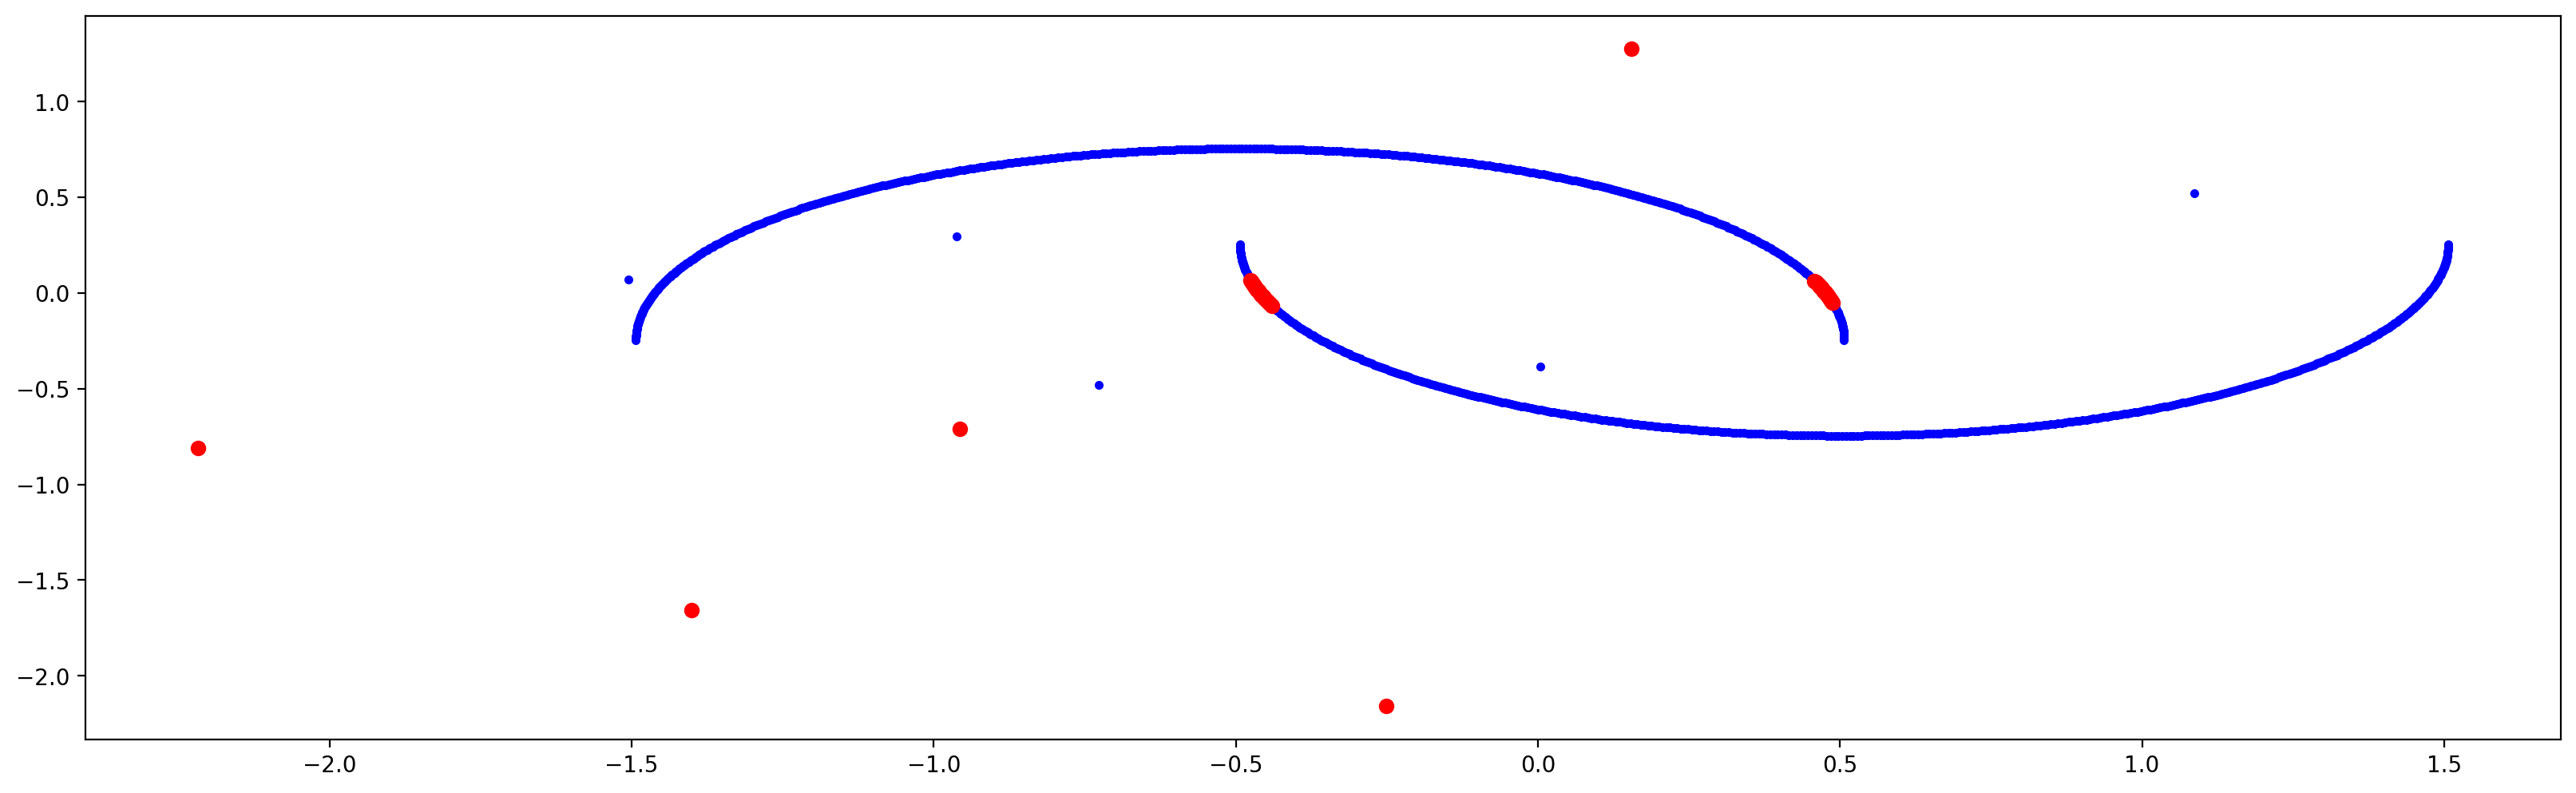

In [ ]:
with torch.no_grad():
    s = model(torch.tensor(X).float())
    anomalies = (s - s.mean()) > 0.5
    plt.subplot(121)
    plt.hist(s - s.mean(),128)
    print(s.std())
    plt.subplot(122)
    plt.plot(s - s.mean())
    plt.show()
    plt.plot(X[~anomalies,0],X[~anomalies,1],'b.')
    plt.plot(X[anomalies,0],X[anomalies,1],'ro')
    plt.show()

# Example with training MNIST & EMNIST

---



In [ ]:
train_loader = torch.utils.data.DataLoader(
  MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 # (0.1307,), (0.3081,))
                                 (0.5),(0.5,))
                             ])),
  batch_size=1024, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    EMNIST(root="files/", split="byclass", download=True, train=True, 
                transform=torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize((0.5),(0.5,))
                ])),
    batch_size=1024)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting files/EMNIST/raw/gzip.zip to files/EMNIST/raw


  0%|          | 0/10 [00:00<?, ?it/s]

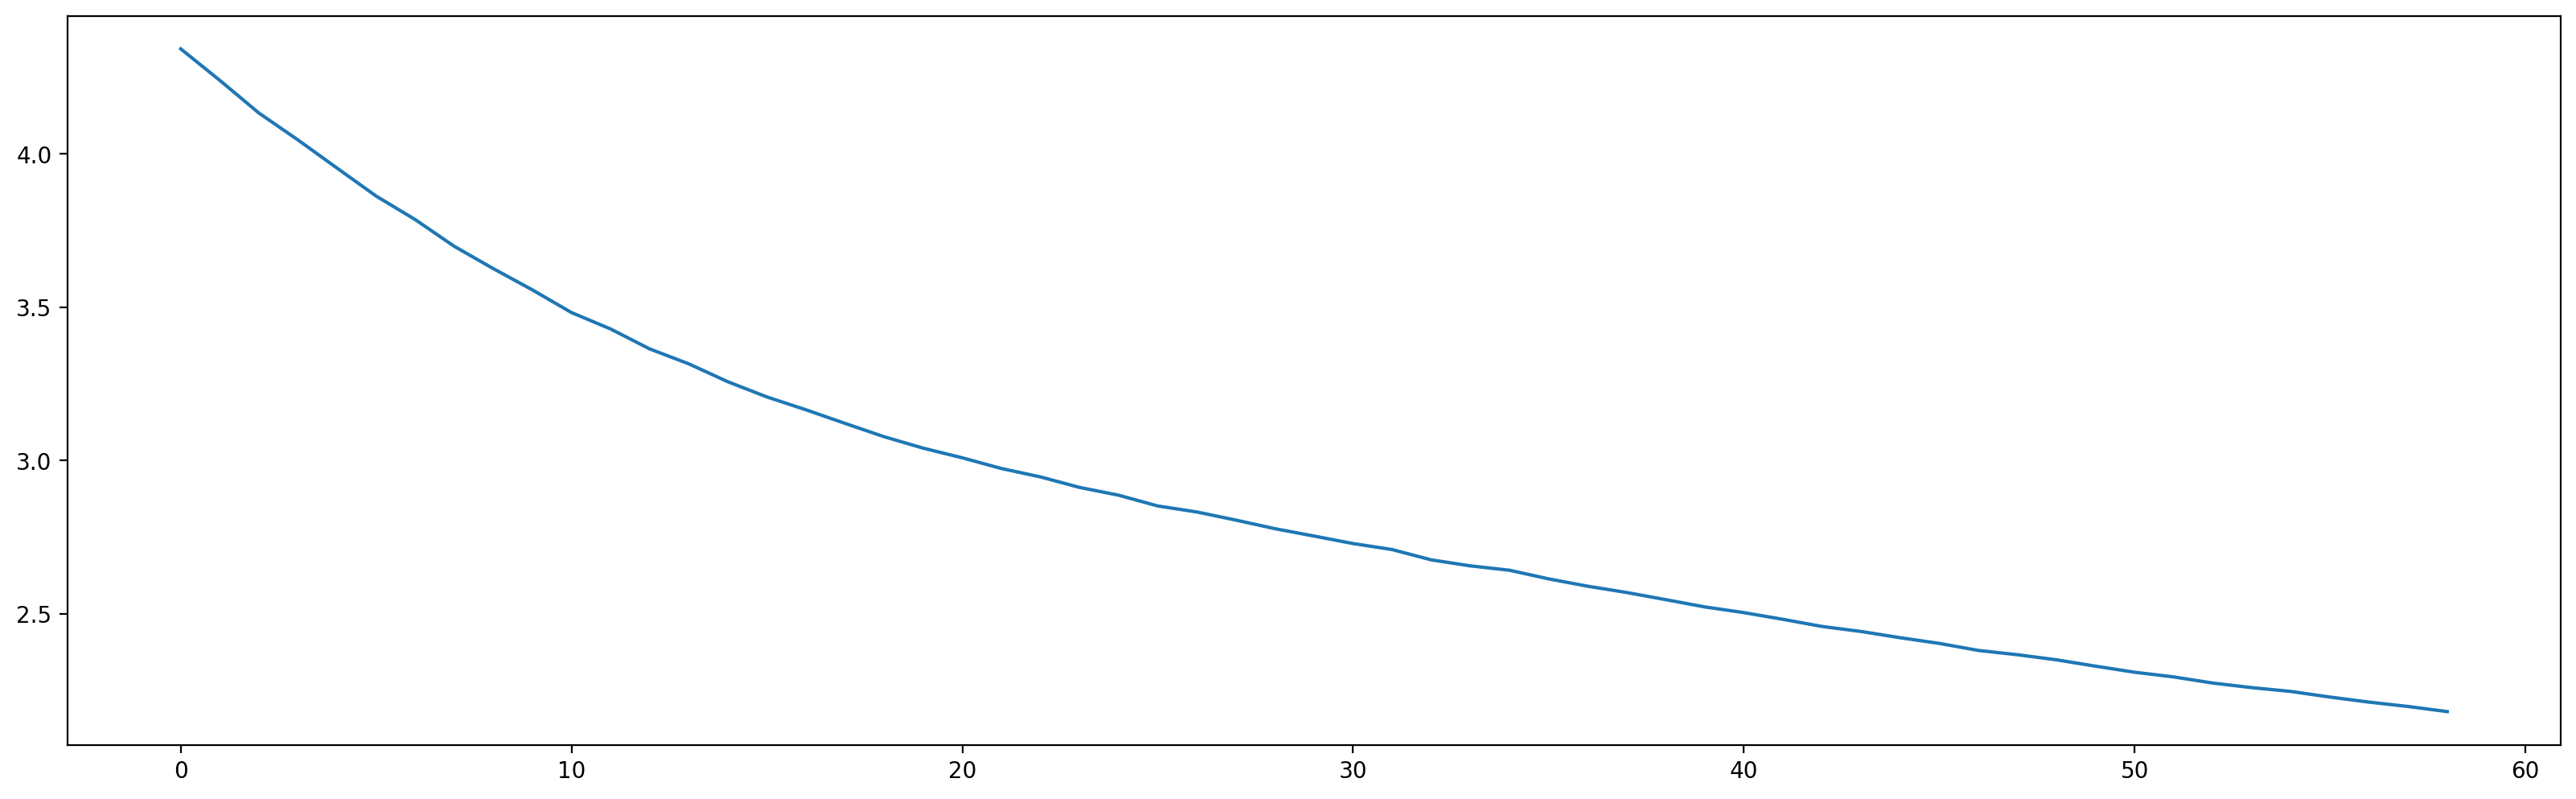

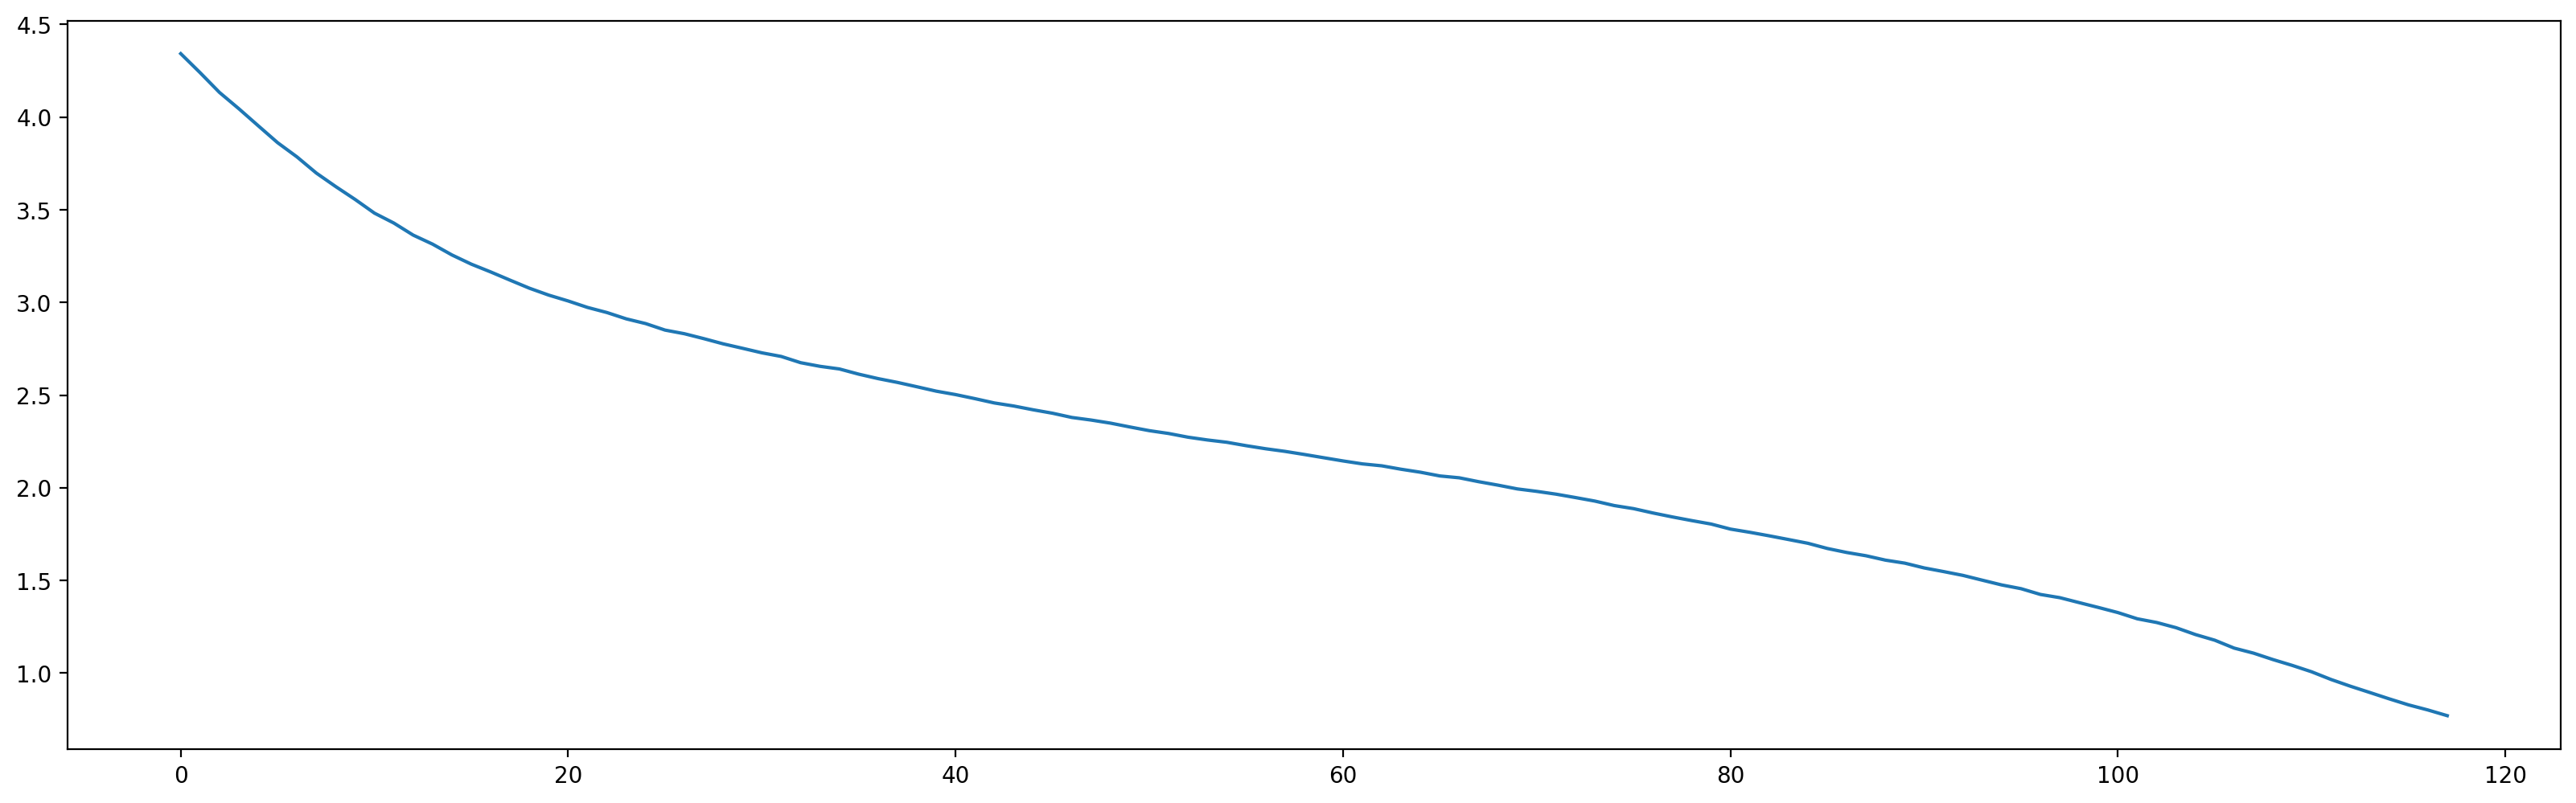

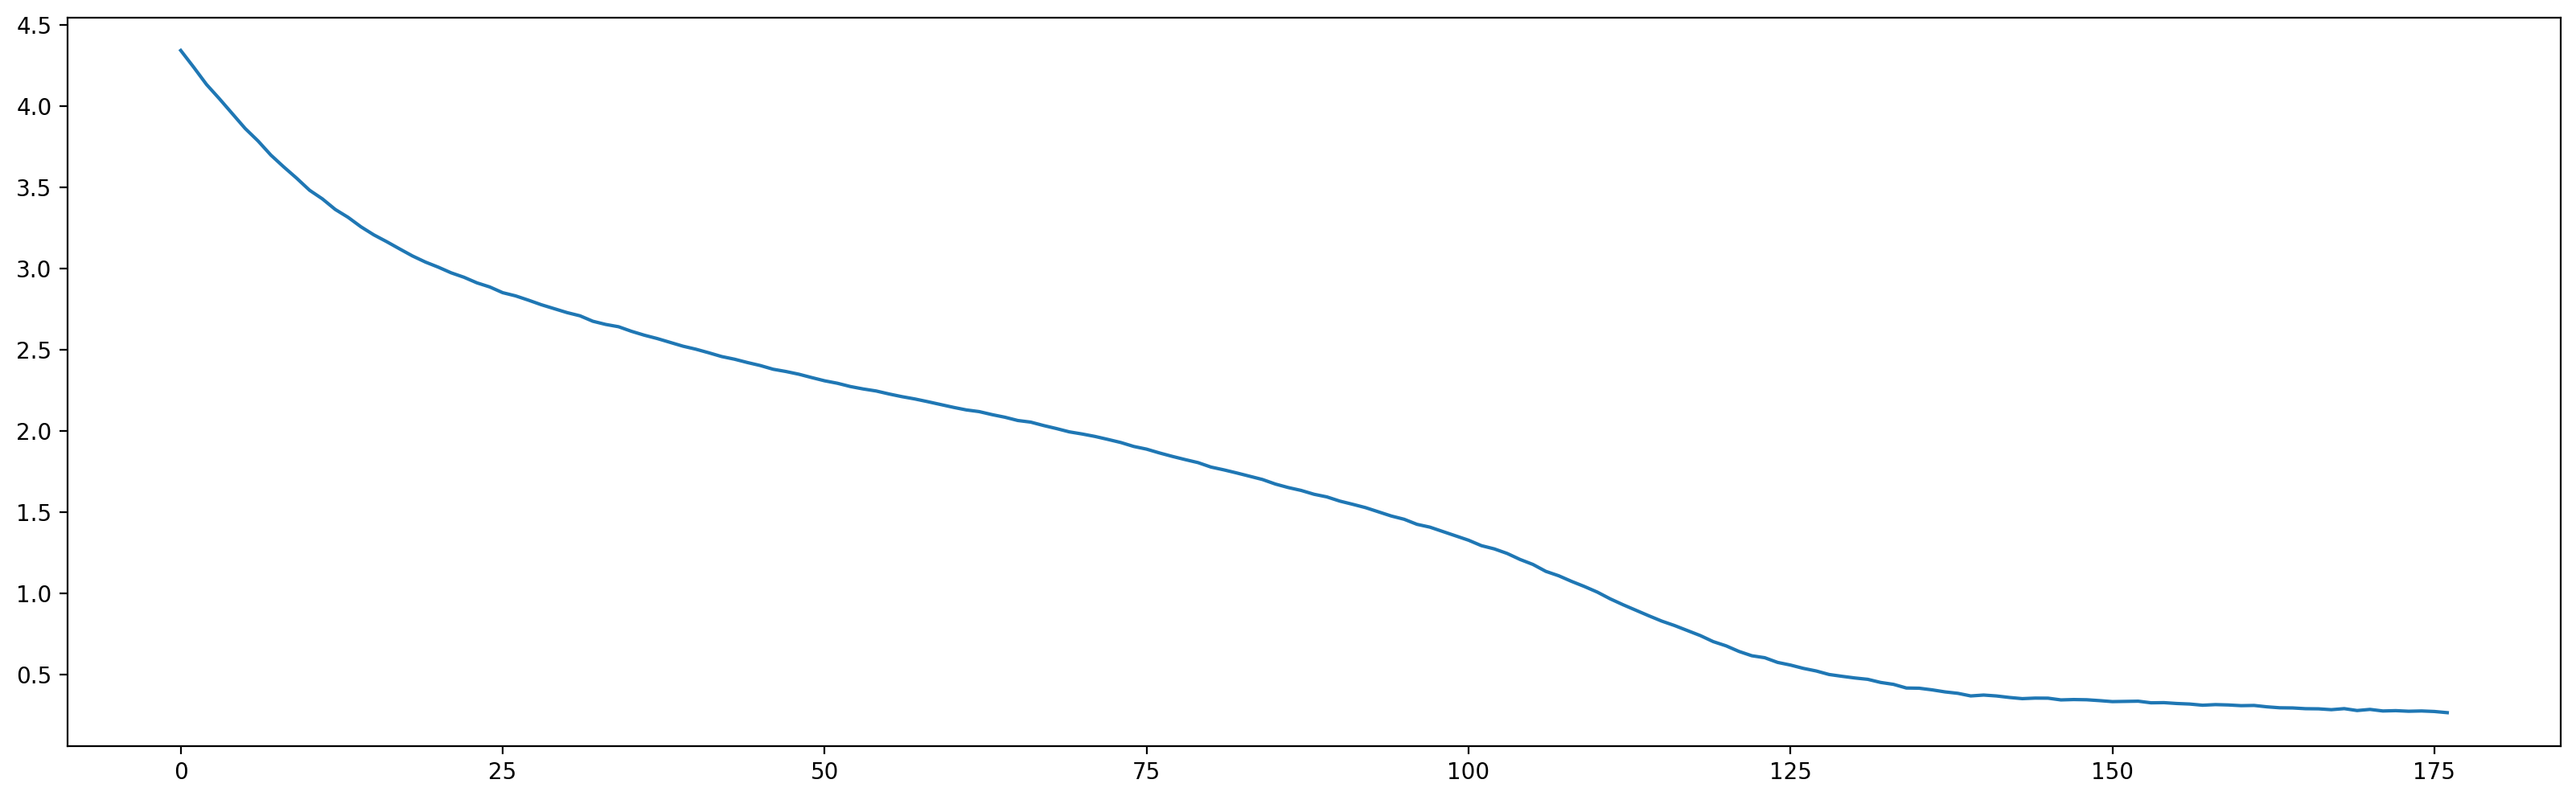

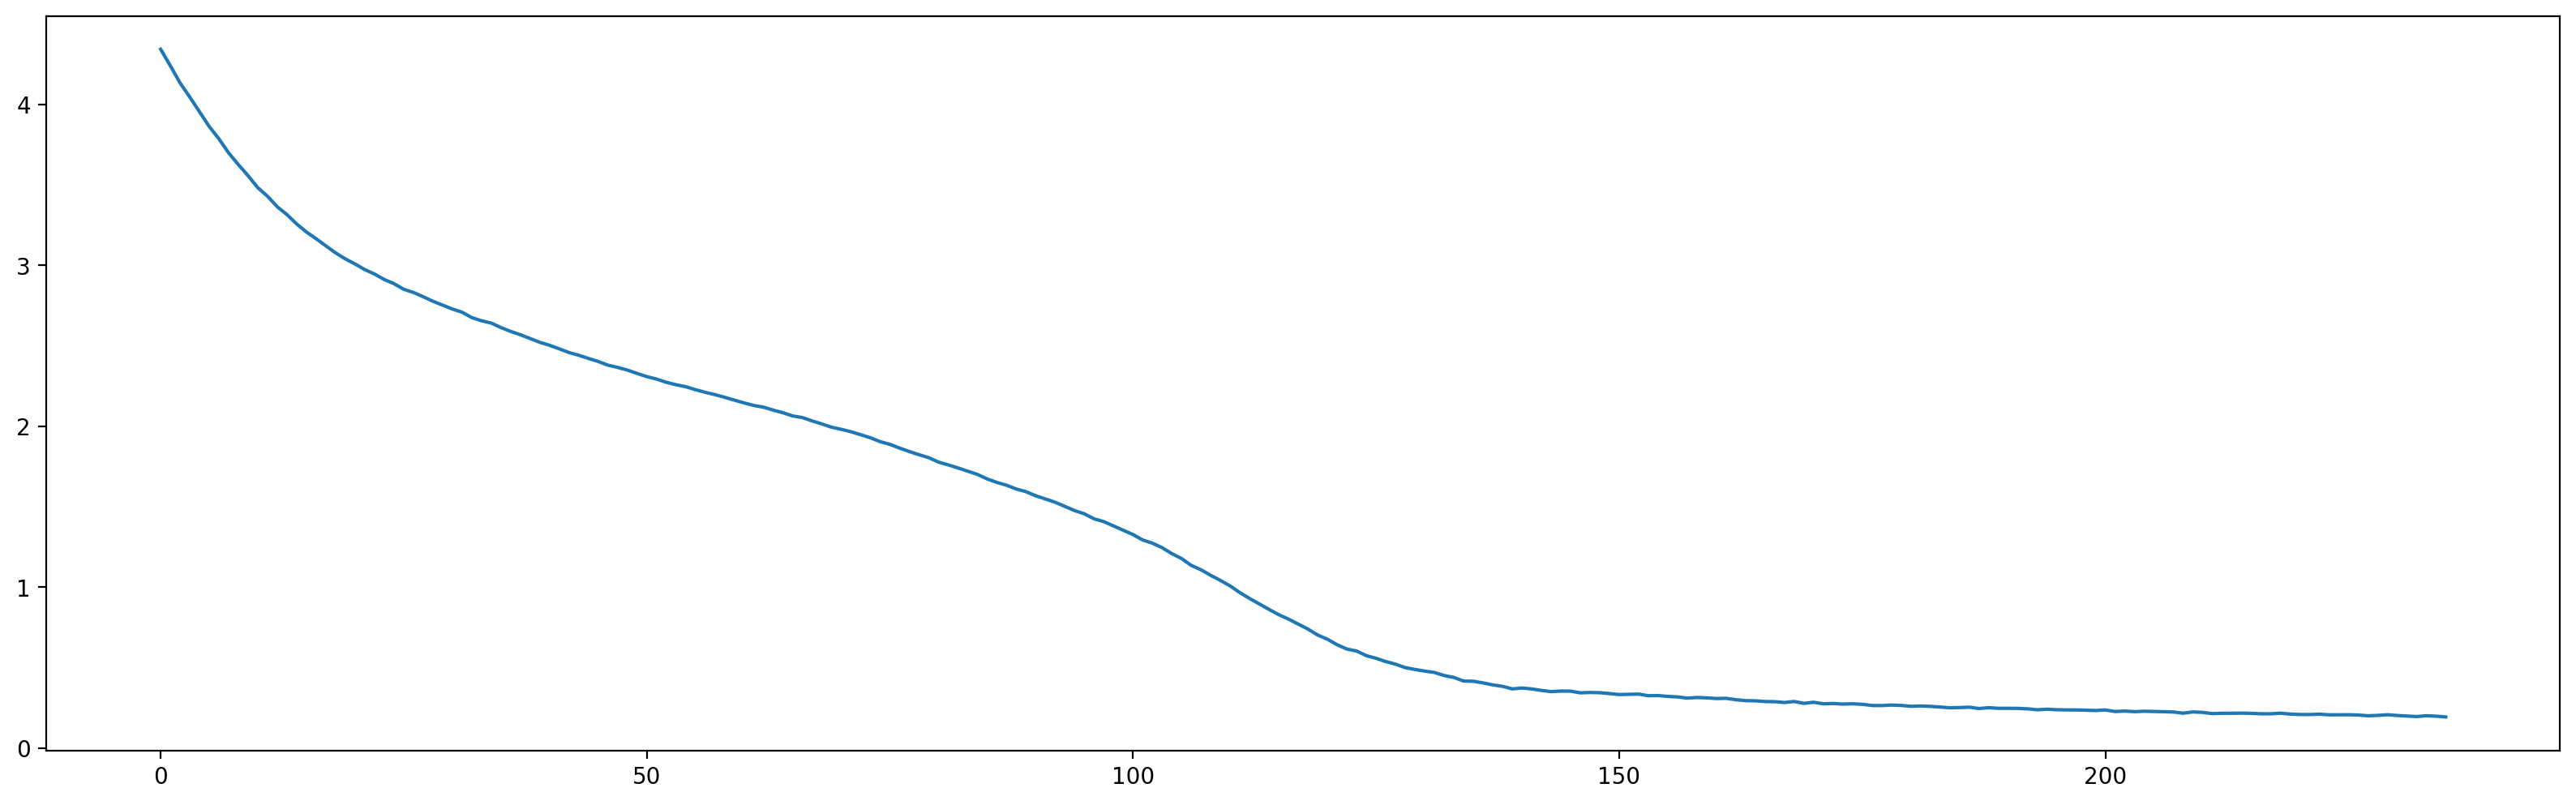

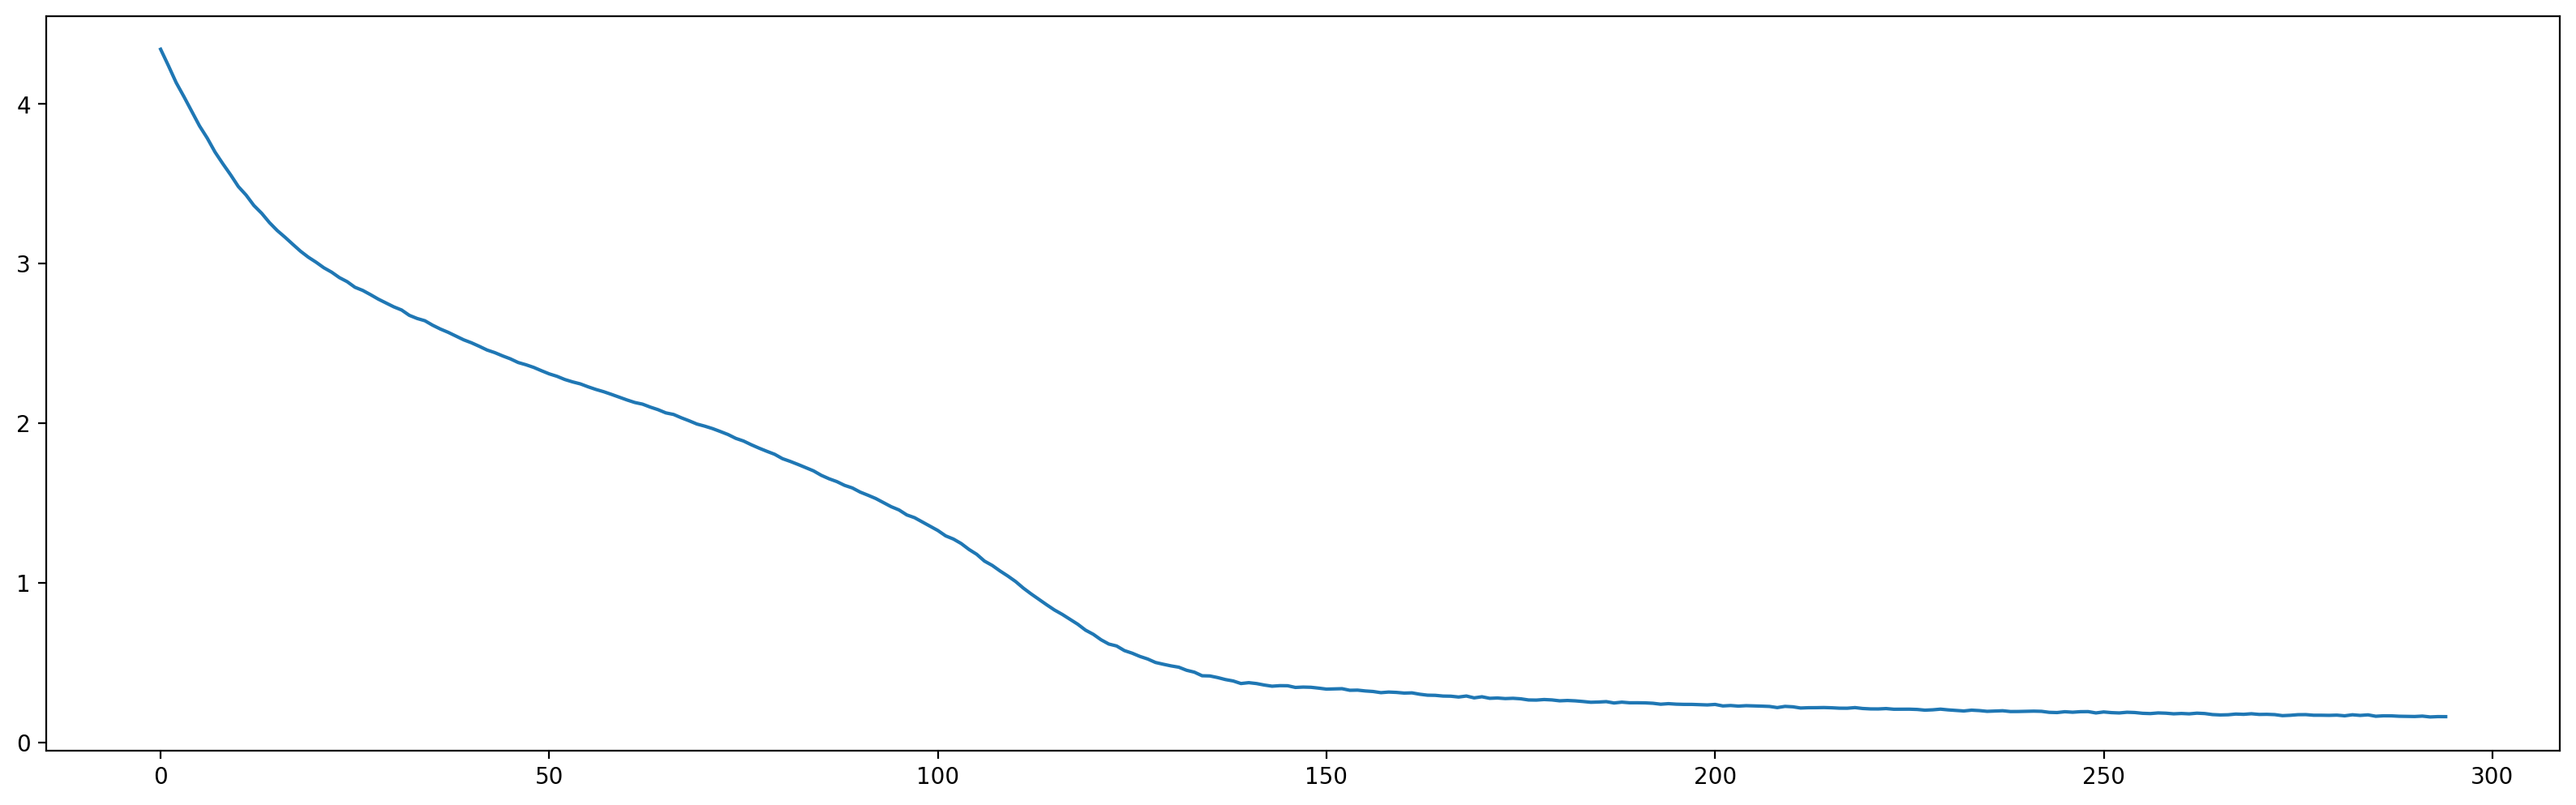

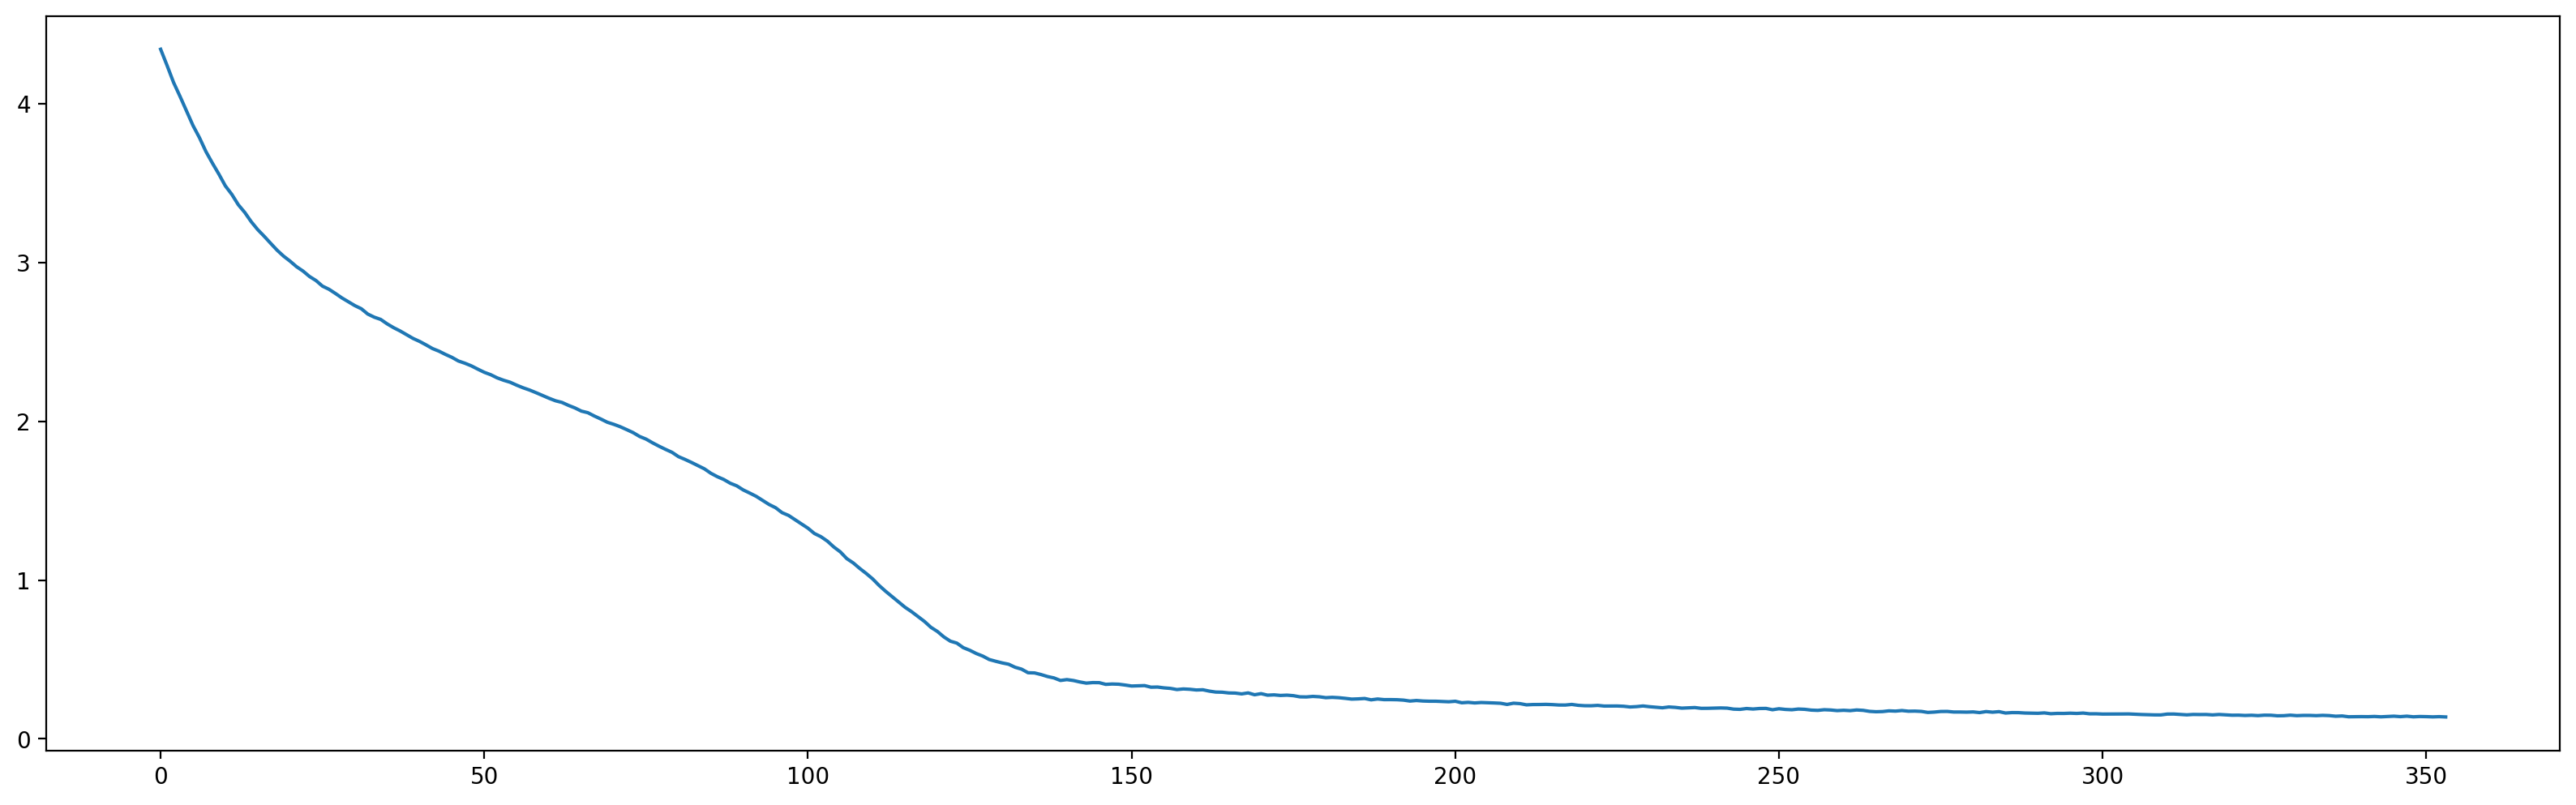

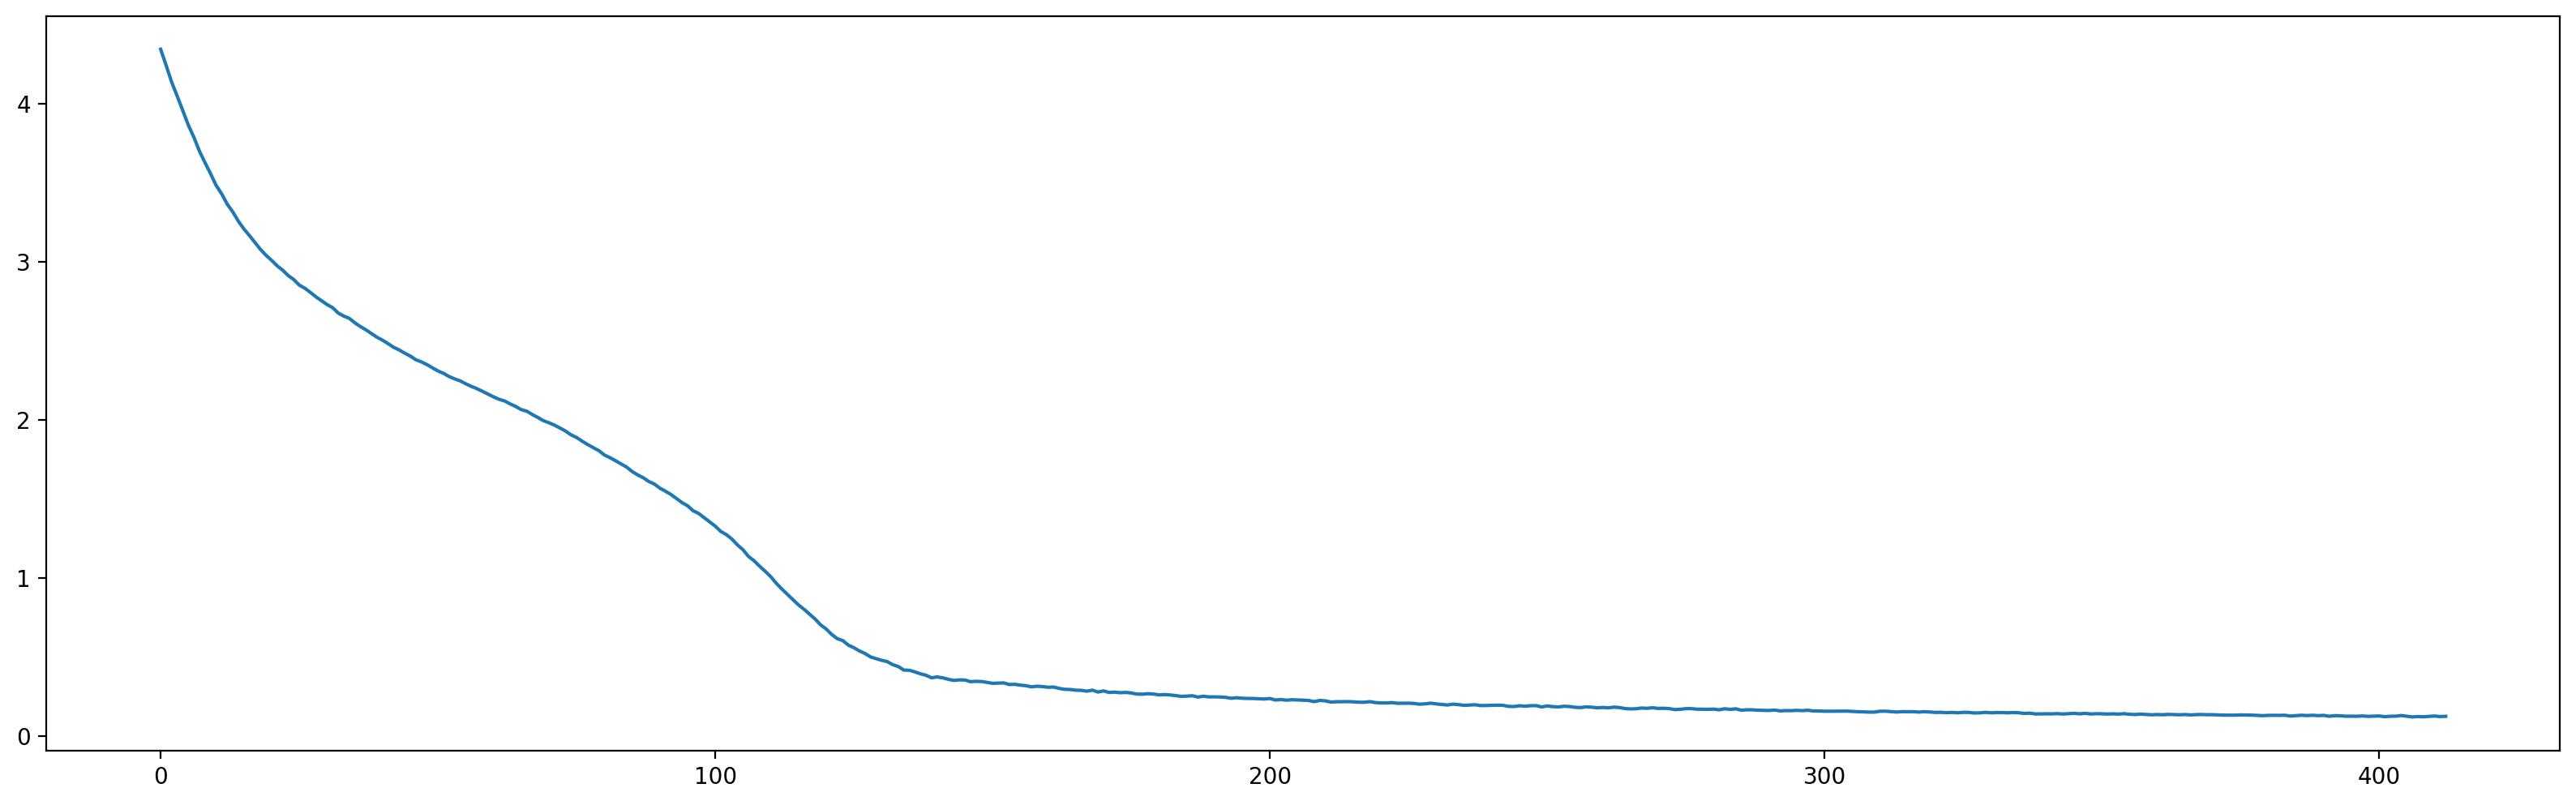

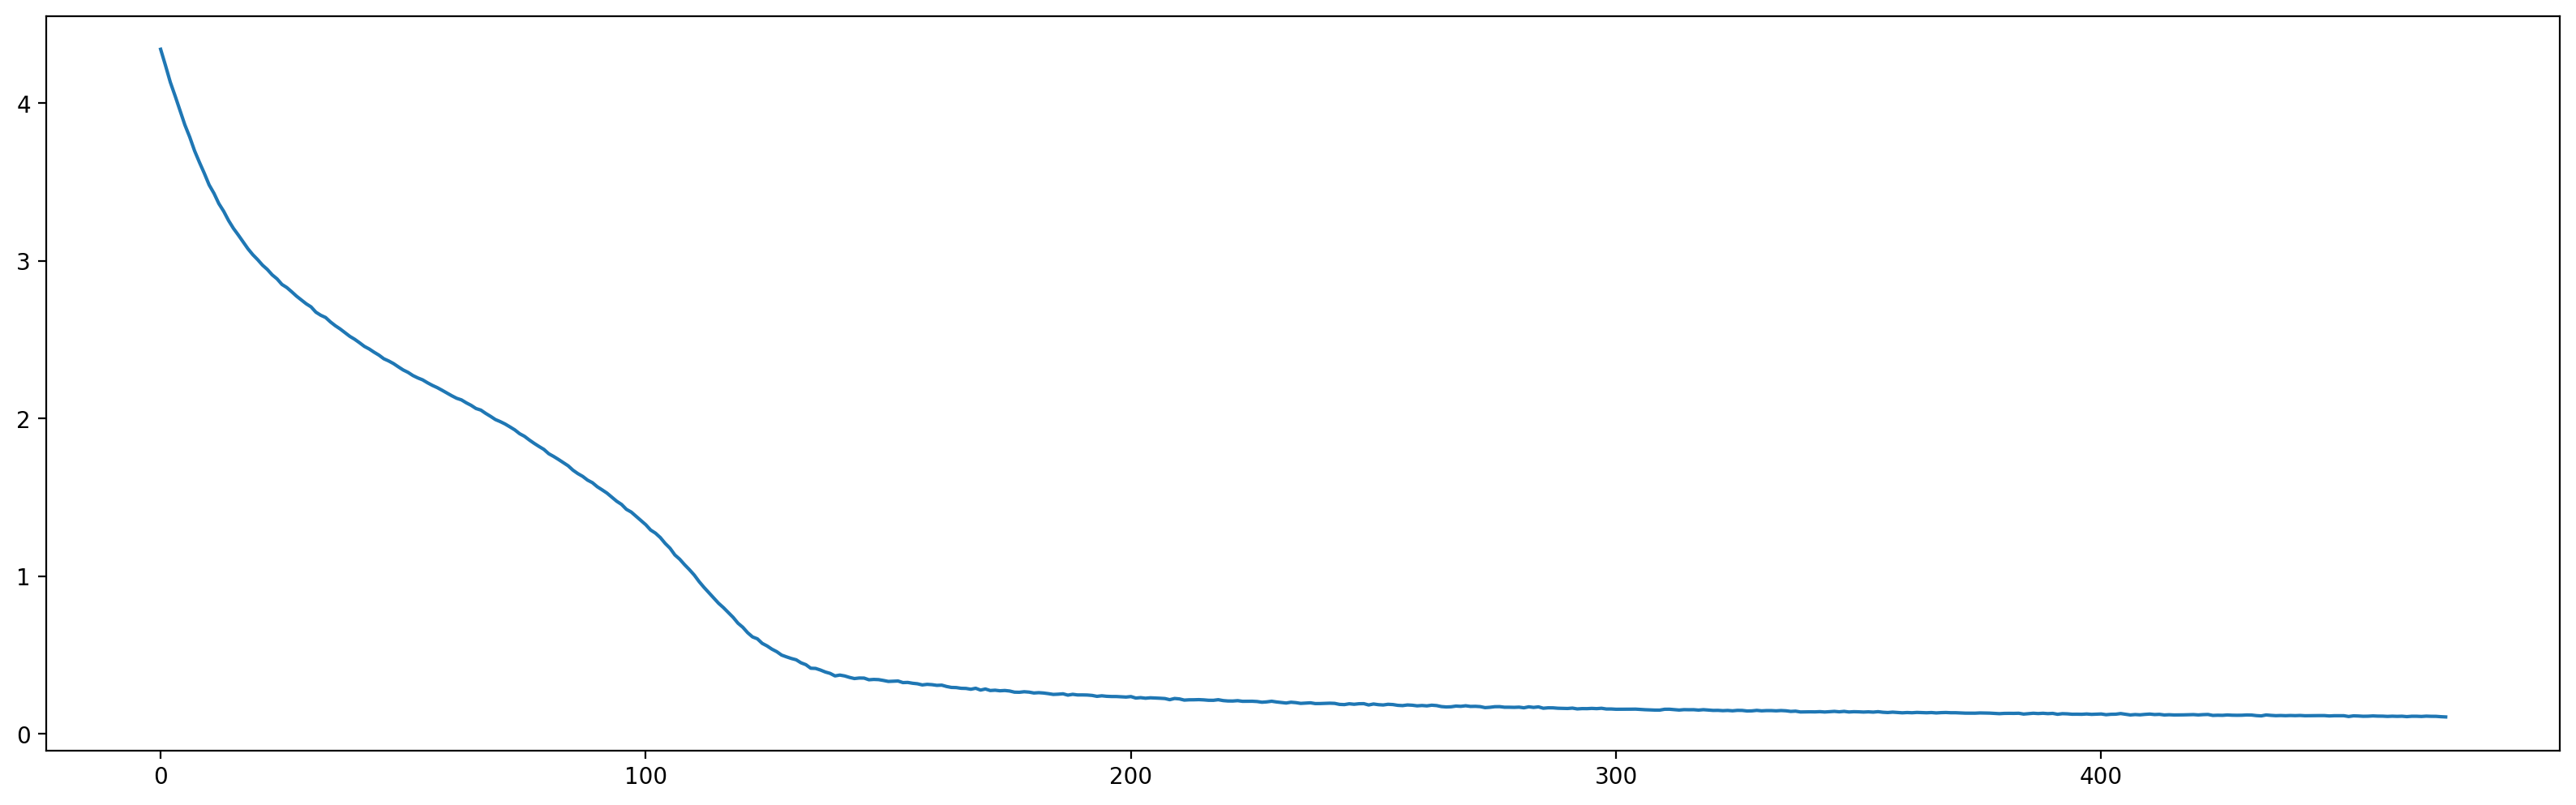

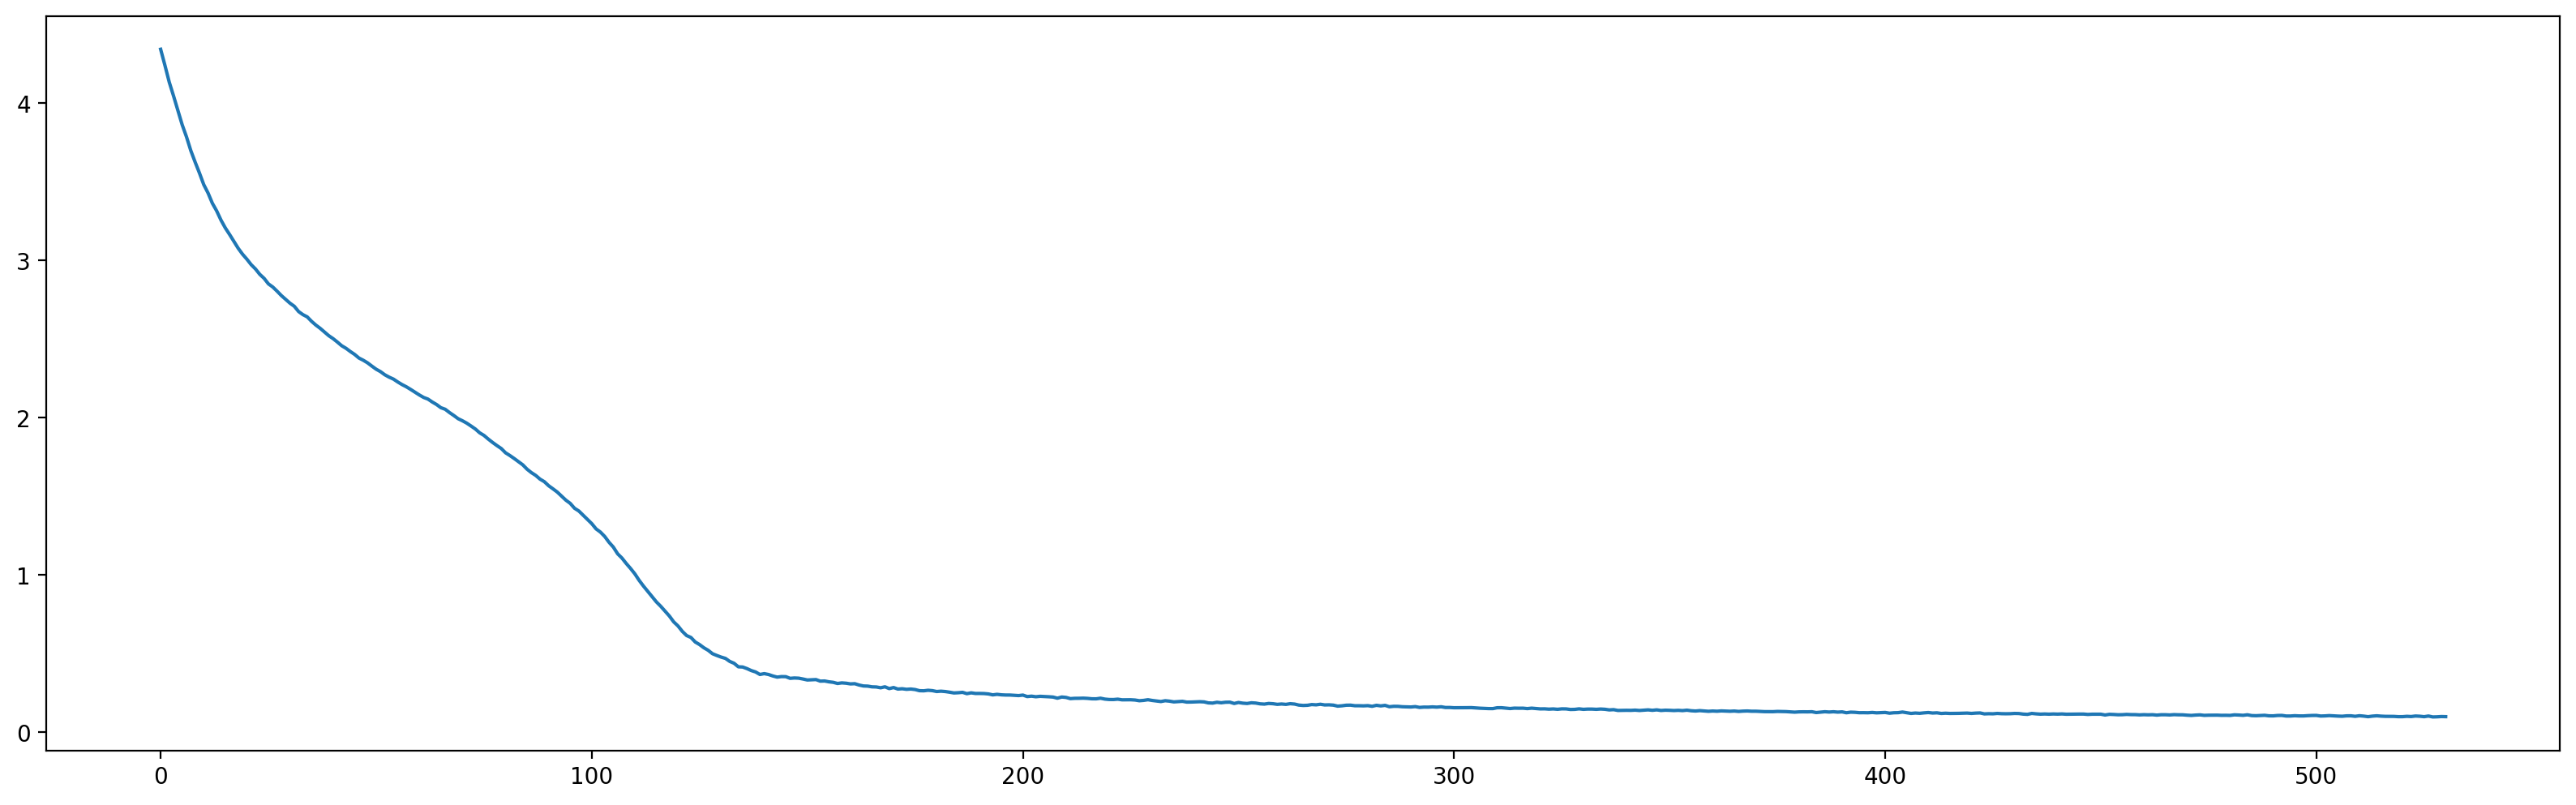

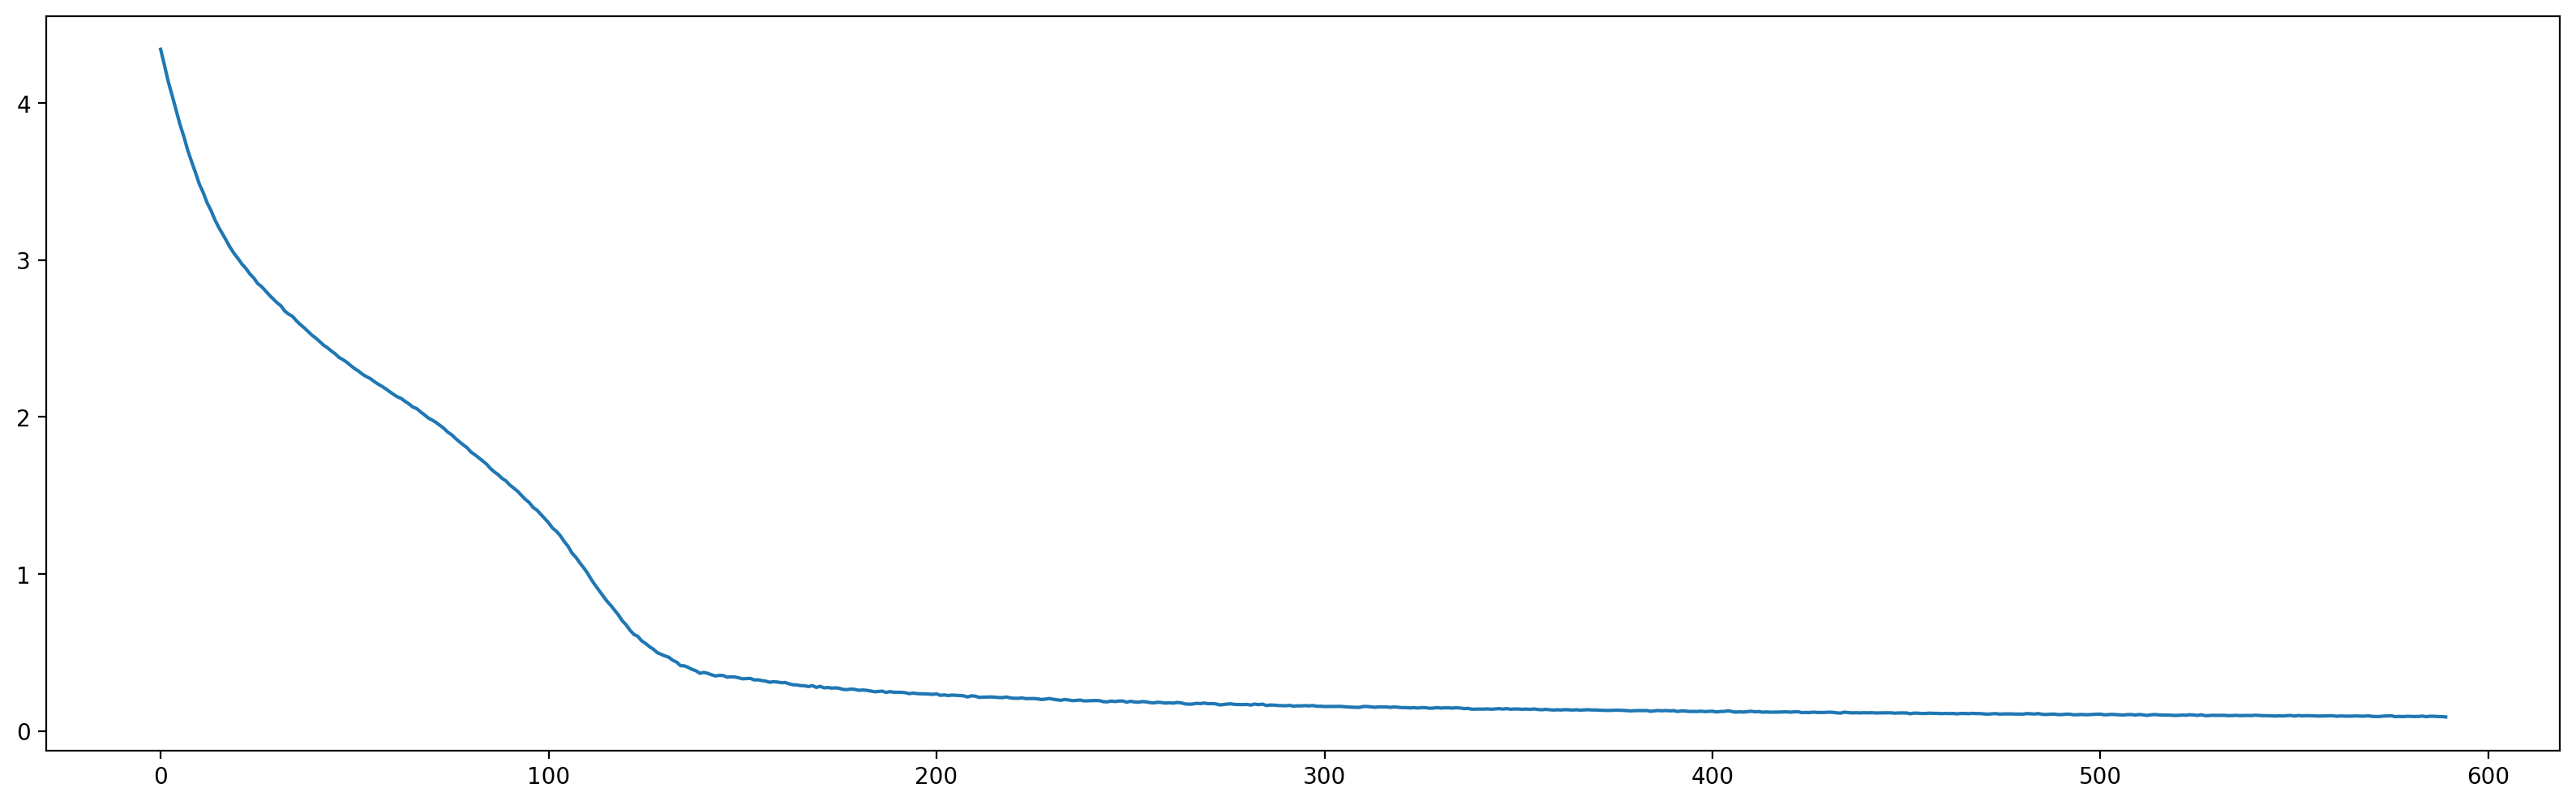

In [ ]:
class MNISTNetwork(nn.Module):
    def __init__(self):
        super(MNISTNetwork, self).__init__()
        '''
        self.network = nn.Sequential(
            # CNN
            nn.Conv2d(1,4,(3,3), stride = 2, bias = False),
            nn.Conv2d(4,8,(3,3), stride = 2, bias = False),
            nn.Conv2d(8,16,(3,3), stride = 2, bias = False),
            nn.Flatten(),
            nn.Linear(64, 8, bias = False))
        '''
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 32, bias = False),
            nn.ReLU(),
            nn.Linear(32, 16, bias = False))
        # just making sure that this remains fixed to prevent trivial solutions
        # e.g. all w = 0, c = 0
        self.c = torch.randn(16, requires_grad = False) 

    def forward(self, x):
        x = self.network(x)
        return torch.linalg.vector_norm(x - self.c, dim = -1), x

device = 'cpu'
epochs = 10
model = MNISTNetwork().to(device)
model.c = model.c.to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.0001)
losses = []
for epoch in tqdm(range(epochs)):
    for batch,_ in train_loader:
        s = model(batch.to(device))[0]
        loss = s.mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    plt.plot(losses)
    plt.show()

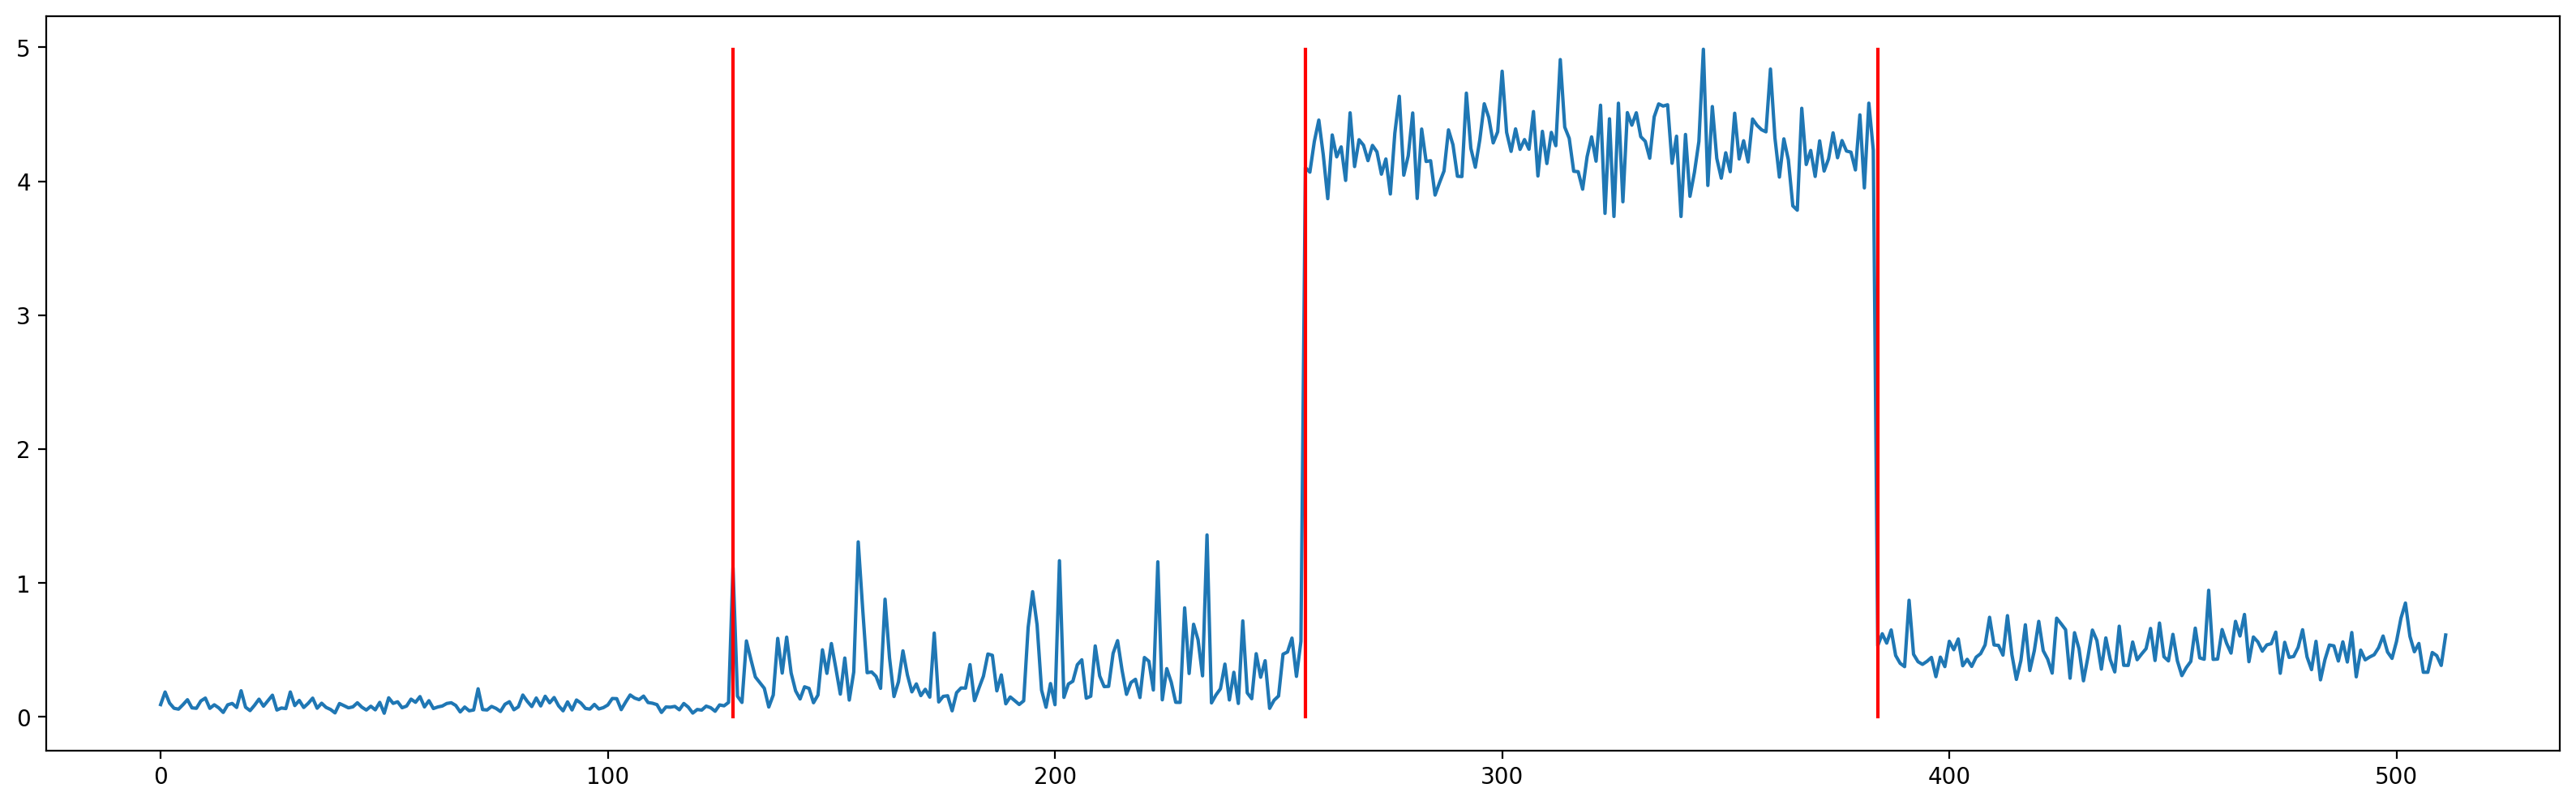

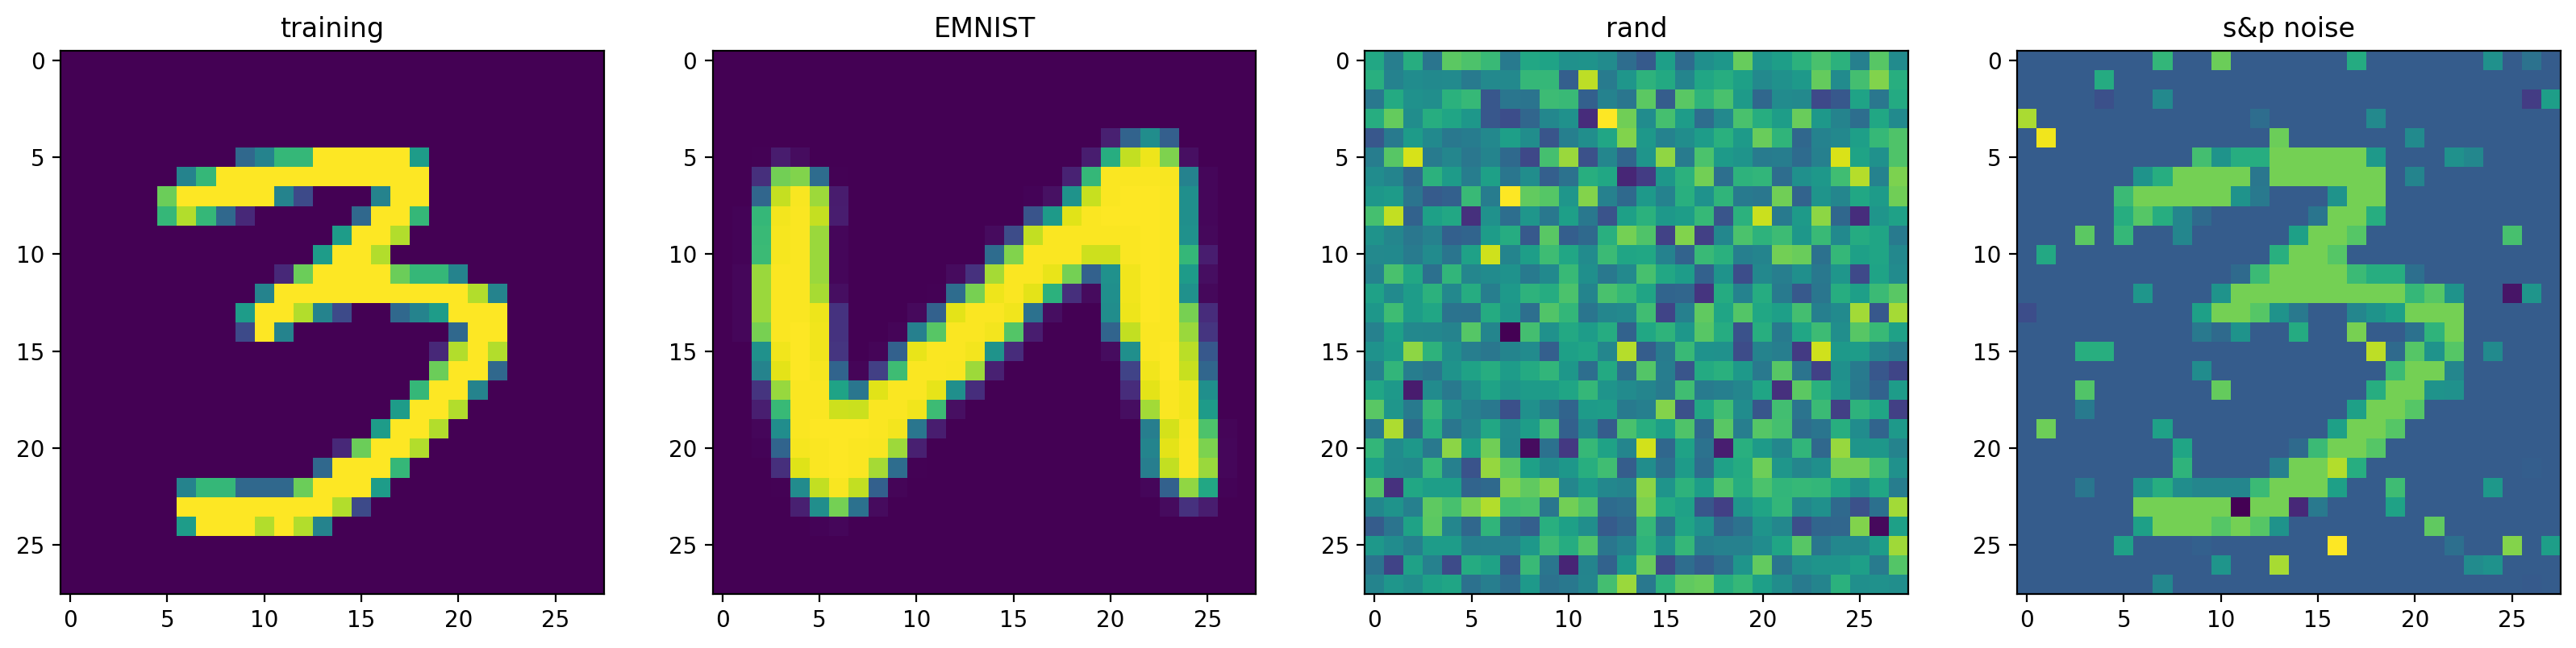

In [ ]:
def salt_and_pepper(x, ratio):
    N = int(ratio * x.numel())
    indices = torch.randint(0,x.numel(),(N,))
    x[indices] = torch.randn(N)
    return x

N = 128
batch_train = next(iter(train_loader))[0][:N]
batch_test = next(iter(test_loader))[0][:N]

with torch.no_grad():
    # random noise
    x_random = torch.randn((batch_train.shape[0],1,28,28))
    # salt and pepper
    x_sp = batch_train.clone()
    x_sp = salt_and_pepper(x_sp.ravel(),0.1).reshape(x_sp.shape)
    # EMNIST

    batch_ = torch.cat((batch_train,batch_test, x_random,x_sp))
    s = model(batch_)[0]
    plt.plot(s)
    plt.plot([N,N],[0,s.max()],'r-')
    plt.plot([2*N,2*N],[0,s.max()],'r-')
    plt.plot([3*N,3*N],[0,s.max()],'r-')
    plt.show()

    plt.subplot(141)
    plt.imshow(batch_train[0,0,...])
    plt.title('training')
    plt.subplot(142)
    plt.imshow(batch_test[0,0,...])
    plt.title('EMNIST')
    plt.subplot(143)
    plt.title('rand')
    plt.imshow(x_random[0,0,...])
    plt.subplot(144)
    plt.title('s&p noise')
    plt.imshow(x_sp[0,0,...])

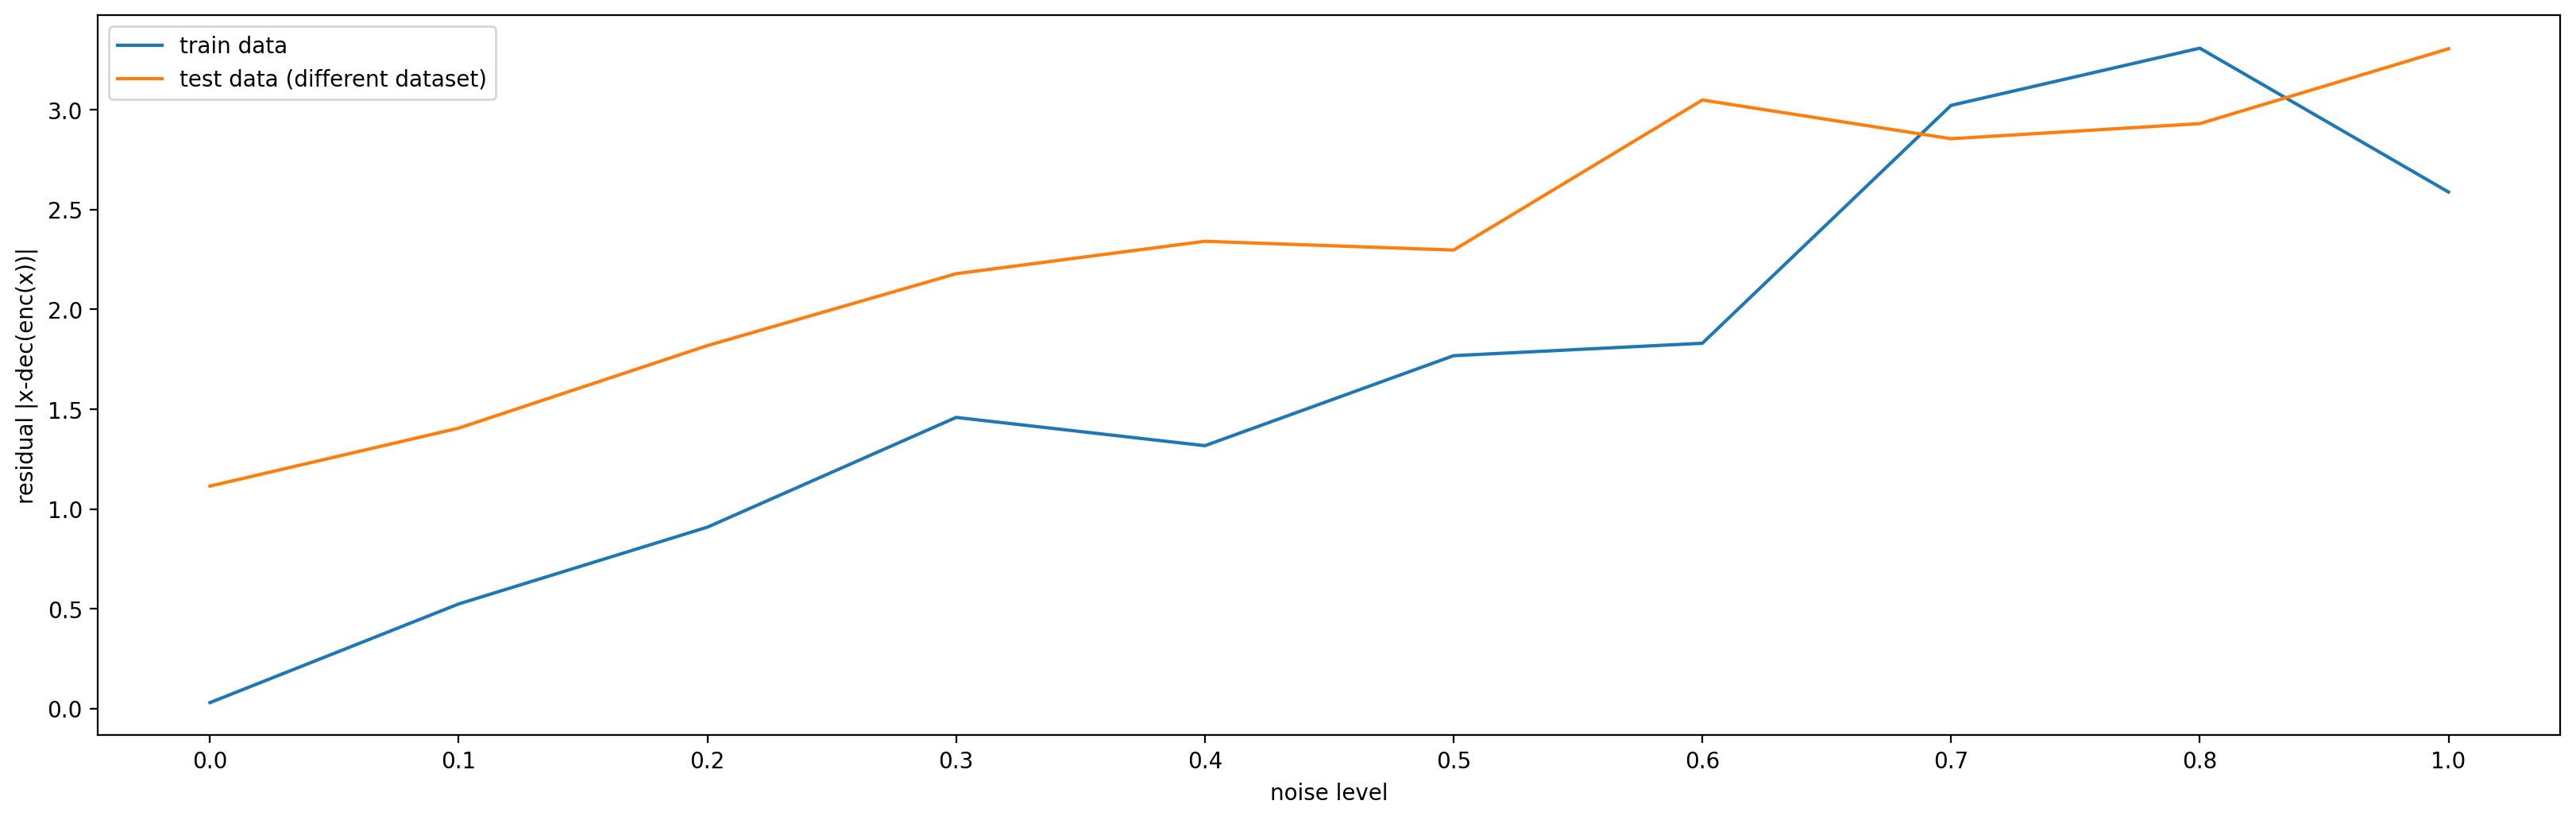

In [ ]:
def noise_levels(x, noise_range, show = True):
    scores = []
    for noise in noise_range:
        x_sp = salt_and_pepper(x.clone().ravel(),noise).reshape(x.shape)
        with torch.no_grad():
            score = model(x_sp)[0]
        if show:
            plt.imshow(x_sp[0,...].cpu())
            plt.title(str(score.item()))
            plt.show()
        scores.append(score)
    return scores

noise_range = torch.linspace(0,1,10)
x_train = next(iter(train_loader))[0]
x_test = next(iter(test_loader))[0]
scores_train = noise_levels(x_train[[0],[0],...], noise_range, False)
scores_test = noise_levels(x_test[[0],[0],...], noise_range, False)

plt.plot(torch.tensor(scores_train).numpy())
plt.plot(torch.tensor(scores_test).numpy())
plt.legend(['train data', 'test data (different dataset)'])
plt.xticks(range(len(noise_range)), (noise_range.numpy() * 10).astype(np.int32).astype(np.float32)/10 )
plt.xlabel('noise level')
plt.ylabel('residual |x-dec(enc(x))|')
plt.show()